In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler

train = pd.read_parquet("../data/ml_final/train_ml_final.parquet")
val   = pd.read_parquet("../data/ml_final/val_ml_final.parquet")
train["error"] = (train["pred_race"] != train["race_true"]).astype(int)
val["error"]   = (val["pred_race"] != val["race_true"]).astype(int)

print(train.shape, val.shape)
print(train.columns[:15])

(7000, 524) (2100, 524)
Index(['pred_gender', 'pred_gender_score', 'pred_race', 'pred_race_score',
       'error', 'file', 'race_true', 'gender_true', 'img_path', 'brightness',
       'contrast', 'saturation', 'emb_0', 'emb_1', 'emb_2'],
      dtype='object')


In [ ]:
# recalculating ROC-AUC with predicted probabilities because the initial calculation 
# I used binary predictions which produces incorrect AUC values

In [80]:
print("recalcualtion all ROC-AUC with probabilities: ")
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.metrics import roc_auc_score

train_clean = train.copy()
val_clean = val.copy()

train_clean["race_true_clean"] = train_clean["race_true"].str.lower().str.replace("_", " ")
train_clean["pred_race_clean"] = train_clean["pred_race"].str.lower()
val_clean["race_true_clean"] = val_clean["race_true"].str.lower().str.replace("_", " ")
val_clean["pred_race_clean"] = val_clean["pred_race"].str.lower()

y_train = (train_clean["race_true_clean"] != train_clean["pred_race_clean"]).astype(int)
y_val = (val_clean["race_true_clean"] != val_clean["pred_race_clean"]).astype(int)

correct_roc_aucs = {}

print("\no embeddings:")
basic_features = ['pred_gender_score', 'pred_race_score', 'brightness', 'contrast', 'saturation']
X_train_no_emb = train_clean[basic_features].values
X_val_no_emb = val_clean[basic_features].values

scaler_no_emb = StandardScaler()
X_train_no_emb_scaled = scaler_no_emb.fit_transform(X_train_no_emb)
X_val_no_emb_scaled = scaler_no_emb.transform(X_val_no_emb)

models_no_emb = {
    "logistic regression (no embed)": LogisticRegression(max_iter=500, random_state=42),
    "knn k=3 (no embed)": KNeighborsClassifier(n_neighbors=3),
    "knn k=5 (no embed)": KNeighborsClassifier(n_neighbors=5),
    "knn k=7 (no embed)": KNeighborsClassifier(n_neighbors=7),
    "random forest (no embed)": RandomForestClassifier(n_estimators=300, random_state=42),
    "svm linear (no embed)": SVC(kernel='linear', probability=True, random_state=42),
    "svm rbf (no embed)": SVC(kernel='rbf', C=2, gamma='scale', probability=True, random_state=42),
}

for name, model in models_no_emb.items():
    print(f"Training {name}...")
    model.fit(X_train_no_emb_scaled, y_train)
    
    if hasattr(model, 'predict_proba'):
        y_pred_proba = model.predict_proba(X_val_no_emb_scaled)[:, 1]
    else:
        y_pred_proba = model.decision_function(X_val_no_emb_scaled)
    
    auc = roc_auc_score(y_val, y_pred_proba)
    correct_roc_aucs[name] = auc
    print(f"  → ROC-AUC: {auc:.4f}")

print("\nwith embeddings:")
X_train = train_clean.select_dtypes(include=[np.number]).values
X_val = val_clean.select_dtypes(include=[np.number]).values

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

models_for_auc = {
    "logistic regression": LogisticRegression(max_iter=500, random_state=42),
    "logistic regression (tuned)": LogisticRegression(C=0.01, penalty="l2", solver="lbfgs", max_iter=10000, random_state=42),
    "knn (k=7)": KNeighborsClassifier(n_neighbors=7),
    "knn (tuned)": KNeighborsClassifier(n_neighbors=9, weights="distance", metric="manhattan"),
    "random forest": RandomForestClassifier(n_estimators=300, random_state=42),
    "random forest (tuned)": RandomForestClassifier(n_estimators=400, max_depth=None, max_features="log2", random_state=42),
    "svm (linear)": SVC(kernel='linear', probability=True, random_state=42),
    "svm (linear tuned)": SVC(kernel='linear', C=10, probability=True, random_state=42),
    "svm (rbf)": SVC(kernel='rbf', C=2, gamma='scale', probability=True, random_state=42),
    "xgboost (tuned)": xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        tree_method="hist",
        learning_rate=0.01,
        max_depth=4,
        n_estimators=200,
        subsample=0.8,
        colsample_bytree=1.0,
        random_state=42
    ),
}

for name, model in models_for_auc.items():
    print(f"Training {name}...")
    model.fit(X_train_scaled, y_train)
    
    if hasattr(model, 'predict_proba'):
        y_pred_proba = model.predict_proba(X_val_scaled)[:, 1]
    else:
        y_pred_proba = model.decision_function(X_val_scaled)
    
    auc = roc_auc_score(y_val, y_pred_proba)
    correct_roc_aucs[name] = auc
    print(f"  → ROC-AUC: {auc:.4f}")

print("\nall ROC-AUC recalculated")
print("\ncorrected values:")
for name, auc in correct_roc_aucs.items():
    print(f"{name:30s} → {auc:.4f}")

recalcualtion all ROC-AUC with probabilities: 

o embeddings:
Training logistic regression (no embed)...
  → ROC-AUC: 0.5877
Training knn k=3 (no embed)...
  → ROC-AUC: 0.5212
Training knn k=5 (no embed)...
  → ROC-AUC: 0.5161
Training knn k=7 (no embed)...
  → ROC-AUC: 0.5260
Training random forest (no embed)...
  → ROC-AUC: 0.6017
Training svm linear (no embed)...
  → ROC-AUC: 0.4596
Training svm rbf (no embed)...
  → ROC-AUC: 0.5672

with embeddings:
Training logistic regression...
  → ROC-AUC: 0.7676
Training logistic regression (tuned)...
  → ROC-AUC: 0.7667
Training knn (k=7)...
  → ROC-AUC: 0.7187
Training knn (tuned)...
  → ROC-AUC: 0.7192
Training random forest...
  → ROC-AUC: 0.7757
Training random forest (tuned)...
  → ROC-AUC: 0.7693
Training svm (linear)...
  → ROC-AUC: 0.7617
Training svm (linear tuned)...
  → ROC-AUC: 0.7633
Training svm (rbf)...
  → ROC-AUC: 0.7655
Training xgboost (tuned)...
  → ROC-AUC: 0.7870

all ROC-AUC recalculated

corrected values:
logistic regr

In [81]:
print("\nPCA MODELS:")
from sklearn.decomposition import PCA

pca = PCA(n_components=100, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)

models_pca = {
    "logistic regression (pca)": LogisticRegression(max_iter=500, random_state=42),
    "logistic regression (pca tuned)": LogisticRegression(C=0.01, penalty="l2", solver="lbfgs", max_iter=10000, random_state=42),
    "knn (pca)": KNeighborsClassifier(n_neighbors=7),
    "knn (pca tuned)": KNeighborsClassifier(n_neighbors=9, weights="distance", metric="manhattan"),
    "random forest (pca)": RandomForestClassifier(n_estimators=300, random_state=42),
    "random forest (pca tuned)": RandomForestClassifier(n_estimators=400, max_depth=None, max_features="log2", random_state=42),
    "svm linear (pca)": SVC(kernel='linear', probability=True, random_state=42),
    "svm linear (pca tuned)": SVC(kernel='linear', C=10, probability=True, random_state=42),
    "svm rbf (pca)": SVC(kernel='rbf', C=2, gamma='scale', probability=True, random_state=42),
    "svm rbf (pca tuned)": SVC(kernel='rbf', C=5, gamma=0.001, probability=True, random_state=42),
    "xgboost (pca)": xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        tree_method="hist",
        learning_rate=0.1,
        max_depth=6,
        n_estimators=300,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    ),
    "xgboost (pca tuned)": xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        tree_method="hist",
        learning_rate=0.01,
        max_depth=4,
        n_estimators=200,
        subsample=0.8,
        colsample_bytree=1.0,
        random_state=42
    ),
}

for name, model in models_pca.items():
    print(f"Training {name}...")
    model.fit(X_train_pca, y_train)
    
    if hasattr(model, 'predict_proba'):
        y_pred_proba = model.predict_proba(X_val_pca)[:, 1]
    else:
        y_pred_proba = model.decision_function(X_val_pca)
    
    auc = roc_auc_score(y_val, y_pred_proba)
    correct_roc_aucs[name] = auc
    print(f"  → ROC-AUC: {auc:.4f}")

print("\nall ROC-AUC recalculated (PCAS)")
print("\ncorrected values:")
for name, auc in correct_roc_aucs.items():
    print(f"{name:35s} → {auc:.4f}")


PCA MODELS:
Training logistic regression (pca)...
  → ROC-AUC: 0.7676
Training logistic regression (pca tuned)...
  → ROC-AUC: 0.7667
Training knn (pca)...
  → ROC-AUC: 0.7187
Training knn (pca tuned)...
  → ROC-AUC: 0.7218
Training random forest (pca)...
  → ROC-AUC: 0.7752
Training random forest (pca tuned)...
  → ROC-AUC: 0.7714
Training svm linear (pca)...
  → ROC-AUC: 0.7616
Training svm linear (pca tuned)...
  → ROC-AUC: 0.7630
Training svm rbf (pca)...
  → ROC-AUC: 0.7655
Training svm rbf (pca tuned)...
  → ROC-AUC: 0.7673
Training xgboost (pca)...
  → ROC-AUC: 0.7830
Training xgboost (pca tuned)...
  → ROC-AUC: 0.7649

all ROC-AUC recalculated (PCAS)

corrected values:
logistic regression (no embed)      → 0.5877
knn k=3 (no embed)                  → 0.5212
knn k=5 (no embed)                  → 0.5161
knn k=7 (no embed)                  → 0.5260
random forest (no embed)            → 0.6017
svm linear (no embed)               → 0.4596
svm rbf (no embed)                  → 0.567

In [82]:
print("\nMissing models:")

print("Training svm (rbf tuned)...")
svm_rbf_tuned = SVC(kernel='rbf', C=5, gamma=0.001, probability=True, random_state=42)
svm_rbf_tuned.fit(X_train_scaled, y_train)
y_pred_proba = svm_rbf_tuned.decision_function(X_val_scaled)
auc = roc_auc_score(y_val, y_pred_proba)
correct_roc_aucs["svm (rbf tuned)"] = auc
print(f"  → ROC-AUC: {auc:.4f}")

print("Training xgboost (normal)...")
xgb_normal = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    tree_method="hist",
    learning_rate=0.1,
    max_depth=6,
    n_estimators=300,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb_normal.fit(X_train_scaled, y_train)
y_pred_proba = xgb_normal.predict_proba(X_val_scaled)[:, 1]
auc = roc_auc_score(y_val, y_pred_proba)
correct_roc_aucs["xgboost (normal)"] = auc
print(f"  → ROC-AUC: {auc:.4f}")

print("\nALL calculated")
print("\ncorrected values:")
for name, auc in correct_roc_aucs.items():
    print(f"{name:35s} → {auc:.4f}")


Missing models:
Training svm (rbf tuned)...
  → ROC-AUC: 0.7673
Training xgboost (normal)...
  → ROC-AUC: 0.7818

ALL calculated

corrected values:
logistic regression (no embed)      → 0.5877
knn k=3 (no embed)                  → 0.5212
knn k=5 (no embed)                  → 0.5161
knn k=7 (no embed)                  → 0.5260
random forest (no embed)            → 0.6017
svm linear (no embed)               → 0.4596
svm rbf (no embed)                  → 0.5672
logistic regression                 → 0.7676
logistic regression (tuned)         → 0.7667
knn (k=7)                           → 0.7187
knn (tuned)                         → 0.7192
random forest                       → 0.7757
random forest (tuned)               → 0.7693
svm (linear)                        → 0.7617
svm (linear tuned)                  → 0.7633
svm (rbf)                           → 0.7655
xgboost (tuned)                     → 0.7870
logistic regression (pca)           → 0.7676
logistic regression (pca tuned)     → 0.7

In [83]:
print("stacking ensemble")

from sklearn.ensemble import StackingClassifier

base_estimators = [
    ('logistic', LogisticRegression(C=0.01, penalty="l2", solver="lbfgs", max_iter=10000, random_state=42)),
    ('knn', KNeighborsClassifier(n_neighbors=9, weights="distance", metric="manhattan")),
    ('rf', RandomForestClassifier(n_estimators=400, max_depth=None, max_features="log2", random_state=42)),
    ('svm_linear', SVC(kernel="linear", C=10, probability=True, random_state=42)),
    ('svm_rbf', SVC(kernel="rbf", C=5, gamma=0.001, probability=True, random_state=42)),
    ('xgboost', xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        tree_method="hist",
        learning_rate=0.01,
        max_depth=4,
        n_estimators=200,
        subsample=0.8,
        colsample_bytree=1.0,
        random_state=42
    ))
]

meta_model = LogisticRegression(max_iter=1000, random_state=42)

print("\nTraining stacking ensemble 6 base models + meta-model")

stacking_clf = StackingClassifier(
    estimators=base_estimators,
    final_estimator=meta_model,
    cv=3,
    stack_method='predict_proba',
    n_jobs=-1
)

stacking_clf.fit(X_train_scaled, y_train)
y_pred_proba = stacking_clf.predict_proba(X_val_scaled)[:, 1]
auc = roc_auc_score(y_val, y_pred_proba)

print(f"stacking ensemble trained:")
print(f"   ROC-AUC: {auc:.4f}")

correct_roc_aucs["stacking ensemble"] = auc

print("all 32 models calculated ")


stacking ensemble

Training stacking ensemble 6 base models + meta-model
stacking ensemble trained:
   ROC-AUC: 0.7534
all 32 models calculated 


In [84]:
metrics = {

    "no embeddings logistic regression": {"acc": 0.6671, "f1": 0.7999, "prec": 0.6681, "rec": 0.9964, "auc": 0.5877},
    "no embeddings knn k=3": {"acc": 0.5814, "f1": 0.6987, "prec": 0.6726, "rec": 0.7268, "auc": 0.5212},
    "no embeddings knn k=5": {"acc": 0.5919, "f1": 0.7129, "prec": 0.6721, "rec": 0.7589, "auc": 0.5161},
    "no embeddings knn k=7": {"acc": 0.6033, "f1": 0.7268, "prec": 0.6727, "rec": 0.7903, "auc": 0.5260},
    "no embeddings random forest": {"acc": 0.6762, "f1": 0.7886, "prec": 0.6990, "rec": 0.9044, "auc": 0.6017},
    "no embeddings svm linear": {"acc": 0.6676, "f1": 0.8007, "prec": 0.6676, "rec": 1.0000, "auc": 0.4596},
    "no embeddings svm rbf": {"acc": 0.6638, "f1": 0.7951, "prec": 0.6703, "rec": 0.9772, "auc": 0.5672},
    "no embeddings baseline": {"acc": 0.6676, "f1": 0.8007, "prec": 0.6676, "rec": 1.0000, "auc": 0.4596},

    "logistic regression": {"acc": 0.7410, "f1": 0.8160, "prec": 0.7761, "rec": 0.8602, "auc": 0.7676},
    "logistic regression tuned": {"acc": 0.7414, "f1": 0.8165, "prec": 0.7759, "rec": 0.8616, "auc": 0.7667},

    "knn k=7": {"acc": 0.7095, "f1": 0.7988, "prec": 0.7429, "rec": 0.8638, "auc": 0.7187},
    "knn tuned": {"acc": 0.6948, "f1": 0.7980, "prec": 0.7149, "rec": 0.9030, "auc": 0.7192},

    "random forest": {"acc": 0.7386, "f1": 0.8184, "prec": 0.7631, "rec": 0.8823, "auc": 0.7757},
    "random forest tuned": {"acc": 0.7338, "f1": 0.8245, "prec": 0.7364, "rec": 0.9365, "auc": 0.7693},

    "svm linear": {"acc": 0.7581, "f1": 0.8308, "prec": 0.7794, "rec": 0.8894, "auc": 0.7617},
    "svm linear tuned": {"acc": 0.7562, "f1": 0.8297, "prec": 0.7774, "rec": 0.8894, "auc": 0.7633},

    "svm rbf": {"acc": 0.7348, "f1": 0.8111, "prec": 0.7731, "rec": 0.8531, "auc": 0.7655},
    "svm rbf tuned": {"acc": 0.6676, "f1": 0.8007, "prec": 0.6676, "rec": 1.0000, "auc": 0.7673},

    "logistic regression pca": {"acc": 0.6814, "f1": 0.7399, "prec": 0.8130, "rec": 0.6790, "auc": 0.7676},
    "logistic regression pca tuned": {"acc": 0.7410, "f1": 0.8160, "prec": 0.7761, "rec": 0.8602, "auc": 0.7667},

    "knn pca": {"acc": 0.7095, "f1": 0.7988, "prec": 0.7429, "rec": 0.8638, "auc": 0.7187},
    "knn pca tuned": {"acc": 0.7238, "f1": 0.8153, "prec": 0.7365, "rec": 0.9130, "auc": 0.7218},

    "random forest pca": {"acc": 0.7362, "f1": 0.8079, "prec": 0.7861, "rec": 0.8310, "auc": 0.7752},
    "random forest pca tuned": {"acc": 0.7243, "f1": 0.8266, "prec": 0.7124, "rec": 0.9843, "auc": 0.7714},

    "svm linear pca": {"acc": 0.6914, "f1": 0.7503, "prec": 0.8157, "rec": 0.6947, "auc": 0.7616},
    "svm linear pca tuned": {"acc": 0.6938, "f1": 0.7524, "prec": 0.8176, "rec": 0.6969, "auc": 0.7630},

    "svm rbf pca": {"acc": 0.6924, "f1": 0.7492, "prec": 0.8219, "rec": 0.6883, "auc": 0.7655},
    "svm rbf pca tuned": {"acc": 0.6681, "f1": 0.8006, "prec": 0.6684, "rec": 0.9979, "auc": 0.7649},

    "xgboost": {"acc": 0.7443, "f1": 0.8203, "prec": 0.7725, "rec": 0.8745, "auc": 0.7818},
    "xgboost tuned": {"acc": 0.7524, "f1": 0.8344, "prec": 0.7537, "rec": 0.9344, "auc": 0.7870},
    "xgboost pca": {"acc": 0.7481, "f1": 0.8210, "prec": 0.7811, "rec": 0.8652, "auc": 0.7830},
    "xgboost pca tuned": {"acc": 0.7543, "f1": 0.8267, "prec": 0.7811, "rec": 0.8780, "auc": 0.7649},

    "stacking ensemble": {"acc": None, "f1": None, "prec": None, "rec": None, "auc": 0.7534}
}
# as I overwrote some variables I did a full index of them here to analyse the results better

In [87]:
import pandas as pd

df_total = pd.DataFrame([

    # NO EMBEDDINGS
    ["logistic regression (no embed)", 0.6671, 0.7999, 0.6681, 0.9964, 0.5877],
    ["knn k=3 (no embed)",             0.5814, 0.6987, 0.6726, 0.7268, 0.5212],
    ["knn k=5 (no embed)",             0.5919, 0.7129, 0.6721, 0.7589, 0.5161],
    ["knn k=7 (no embed)",             0.6033, 0.7268, 0.6727, 0.7903, 0.5260],
    ["random forest (no embed)",       0.6762, 0.7886, 0.6990, 0.9044, 0.6017],
    ["svm linear (no embed)",          0.6676, 0.8007, 0.6676, 1.0000, 0.4596],
    ["svm rbf (no embed)",             0.6638, 0.7951, 0.6703, 0.9772, 0.5672],

    # EMBEDDINGS
    ["logistic regression",            0.7410, 0.8160, 0.7761, 0.8602, 0.7676],
    ["logistic regression (tuned)",    0.7414, 0.8165, 0.7759, 0.8616, 0.7667],

    ["knn (k=7)",                      0.7095, 0.7988, 0.7429, 0.8638, 0.7187],
    ["knn (tuned)",                    0.6950, 0.7980, 0.7150, 0.9030, 0.7192],

    ["random forest",                  0.7386, 0.8184, 0.7631, 0.8823, 0.7757],
    ["random forest (tuned)",          0.7338, 0.8245, 0.7364, 0.9365, 0.7693],

    ["svm (linear)",                   0.7581, 0.8308, 0.7794, 0.8894, 0.7617],
    ["svm (linear tuned)",             0.7562, 0.8297, 0.7774, 0.8894, 0.7633],

    ["svm (rbf)",                      0.7348, 0.8111, 0.7731, 0.8531, 0.7655],
    ["svm (rbf tuned)",                0.6676, 0.8007, 0.6676, 1.0000, 0.7673],

    # PCAS
    ["logistic regression (pca)",      0.6814, 0.7399, 0.8130, 0.6790, 0.7676],
    ["logistic regression (pca tuned)",0.7410, 0.8160, 0.7761, 0.8602, 0.7667],

    ["knn (pca)",                      0.7095, 0.7988, 0.7429, 0.8638, 0.7187],
    ["knn (pca tuned)",                0.7238, 0.8153, 0.7365, 0.9130, 0.7218],

    ["random forest (pca)",            0.7362, 0.8079, 0.7861, 0.8310, 0.7752],
    ["random forest (pca tuned)",      0.7243, 0.8266, 0.7124, 0.9843, 0.7714],

    ["svm linear (pca)",               0.6914, 0.7503, 0.8157, 0.6947, 0.7616],
    ["svm linear (pca tuned)",         0.6938, 0.7524, 0.8176, 0.6969, 0.7630],

    ["svm rbf (pca)",                  0.6924, 0.7492, 0.8219, 0.6883, 0.7655],
    ["svm rbf (pca tuned)",            0.6681, 0.8006, 0.6684, 0.9979, 0.7649],

    #XGBOOST
    ["xgboost (normal)",               0.7443, 0.8203, 0.7725, 0.8745, 0.7818],
    ["xgboost (tuned)",                0.7524, 0.8344, 0.7537, 0.9344, 0.7870],
    ["xgboost (pca)",                  0.7481, 0.8210, 0.7811, 0.8652, 0.7830],
    ["xgboost (pca tuned)",            0.7543, 0.8267, 0.7811, 0.8780, 0.7649],

    # STACKING 
    ["stacking ensemble",              0.7529, 0.8242, 0.7847, 0.8680, 0.7534],

], columns=["model", "accuracy", "f1_score", "precision", "recall", "roc_auc"])

df_total

,model,accuracy,f1_score,precision,recall,roc_auc
0,logistic regression (no embed),0.6671,0.7999,0.6681,0.9964,0.5877
1,knn k=3 (no embed),0.5814,0.6987,0.6726,0.7268,0.5212
2,knn k=5 (no embed),0.5919,0.7129,0.6721,0.7589,0.5161
3,knn k=7 (no embed),0.6033,0.7268,0.6727,0.7903,0.5260
4,random forest (no embed),0.6762,0.7886,0.6990,0.9044,0.6017
5,svm linear (no embed),0.6676,0.8007,0.6676,1.0000,0.4596
6,svm rbf (no embed),0.6638,0.7951,0.6703,0.9772,0.5672
7,logistic regression,0.7410,0.8160,0.7761,0.8602,0.7676
8,logistic regression (tuned),0.7414,0.8165,0.7759,0.8616,0.7667
9,knn (k=7),0.7095,0.7988,0.7429,0.8638,0.7187


In [88]:
#all my models :

In [110]:
import pandas as pd

key_mapping = {
    "logistic regression (no embed)": "no embeddings logistic regression",
    "knn k=3 (no embed)": "no embeddings knn k=3",
    "knn k=5 (no embed)": "no embeddings knn k=5",
    "knn k=7 (no embed)": "no embeddings knn k=7",
    "random forest (no embed)": "no embeddings random forest",
    "svm linear (no embed)": "no embeddings svm linear",
    "svm rbf (no embed)": "no embeddings svm rbf",
    "logistic regression": "logistic regression",
    "logistic regression (tuned)": "logistic regression tuned",
    "knn (k=7)": "knn k=7",
    "knn (tuned)": "knn tuned",
    "random forest": "random forest",
    "random forest (tuned)": "random forest tuned",
    "svm (linear)": "svm linear",
    "svm (linear tuned)": "svm linear tuned",
    "svm (rbf)": "svm rbf",
    "svm (rbf tuned)": "svm rbf tuned",
    "logistic regression (pca)": "logistic regression pca",
    "logistic regression (pca tuned)": "logistic regression pca tuned",
    "knn (pca)": "knn pca",
    "knn (pca tuned)": "knn pca tuned",
    "random forest (pca)": "random forest pca",
    "random forest (pca tuned)": "random forest pca tuned",
    "svm linear (pca)": "svm linear pca",
    "svm linear (pca tuned)": "svm linear pca tuned",
    "svm rbf (pca)": "svm rbf pca",
    "svm rbf (pca tuned)": "svm rbf pca tuned",
    "xgboost (normal)": "xgboost",
    "xgboost (tuned)": "xgboost tuned",
    "xgboost (pca)": "xgboost pca",
    "xgboost (pca tuned)": "xgboost pca tuned",
    "stacking ensemble": "stacking ensemble",
}

for new_key, old_key in key_mapping.items():
    if new_key in correct_roc_aucs and old_key in metrics:
        metrics[old_key]["auc"] = correct_roc_aucs[new_key]

metrics["stacking ensemble"] = {
    "acc": 0.7529,
    "f1": 0.8242,
    "prec": 0.7847,
    "rec": 0.8680,
    "auc": correct_roc_aucs["stacking ensemble"]
}

family_order = {
    "no embeddings": 0,
    "embeddings": 1,
    "embeddings tuned": 2,
    "pca": 3,
    "pca tuned": 4,
    "xgboost": 5,
    "xgboost tuned": 6,
}

model_family = {
    "no embeddings logistic regression": "no embeddings",
    "no embeddings knn k=3": "no embeddings",
    "no embeddings knn k=5": "no embeddings",
    "no embeddings knn k=7": "no embeddings",
    "no embeddings random forest": "no embeddings",
    "no embeddings svm linear": "no embeddings",
    "no embeddings svm rbf": "no embeddings",
    "no embeddings baseline": "no embeddings",
    "logistic regression": "embeddings",
    "logistic regression tuned": "embeddings tuned",
    "knn k=7": "embeddings",
    "knn tuned": "embeddings tuned",
    "random forest": "embeddings",
    "random forest tuned": "embeddings tuned",
    "svm linear": "embeddings",
    "svm linear tuned": "embeddings tuned",
    "svm rbf": "embeddings",
    "svm rbf tuned": "embeddings tuned",
    "logistic regression pca": "pca",
    "logistic regression pca tuned": "pca tuned",
    "knn pca": "pca",
    "knn pca tuned": "pca tuned",
    "random forest pca": "pca",
    "random forest pca tuned": "pca tuned",
    "svm linear pca": "pca",
    "svm linear pca tuned": "pca tuned",
    "svm rbf pca": "pca",
    "svm rbf pca tuned": "pca tuned",
    "xgboost": "xgboost",
    "xgboost tuned": "xgboost tuned",
    "xgboost pca": "xgboost",
    "xgboost pca tuned": "xgboost tuned",
    "stacking ensemble": "embeddings tuned",
}

comments = {
    "no embeddings logistic regression": "baseline features, no learning",
    "no embeddings knn k=3": "weak model, unstable",
    "no embeddings knn k=5": "slight improvement, still weak",
    "no embeddings knn k=7": "best knn baseline, still poor",
    "no embeddings random forest": "slightly better, still weak",
    "no embeddings svm linear": "predicts only class 1",
    "no embeddings svm rbf": "weak recall",
    "no embeddings baseline": "random baseline",
    "logistic regression": "embeddings give strong boost",
    "logistic regression tuned": "very small gain",
    "knn k=7": "ok but below stronger models",
    "knn tuned": "higher recall, unstable",
    "random forest": "good overall boost",
    "random forest tuned": "strong recall gain",
    "svm linear": "best classical model",
    "svm linear tuned": "tiny tuning effect",
    "svm rbf": "weaker than linear",
    "svm rbf tuned": "collapses",
    "logistic regression pca": "signal reduced",
    "logistic regression pca tuned": "slight gain",
    "knn pca": "similar behaviour",
    "knn pca tuned": "better recall",
    "random forest pca": "good balance",
    "random forest pca tuned": "recall high, precision low",
    "svm linear pca": "balanced but weak",
    "svm linear pca tuned": "small gain",
    "svm rbf pca": "ok but not strong",
    "svm rbf pca tuned": "collapse",
    "xgboost": "strong model",
    "xgboost tuned": "best model",
    "xgboost pca": "still strong",
    "xgboost pca tuned": "slight improvement",
    "stacking ensemble": "strong ensemble",
}

rows = []
for model_name, vals in metrics.items():
    fam = model_family[model_name]
    rows.append({
        "family_order": family_order[fam],
        "family": fam,
        "model": model_name,
        "accuracy": vals["acc"],
        "f1_score": vals["f1"],
        "precision": vals["prec"],
        "recall": vals["rec"],
        "roc_auc": vals["auc"],
        "comment": comments[model_name]
    })

df_sorted = pd.DataFrame(rows).sort_values(
    ["family_order", "f1_score"], ascending=[True, False]
).reset_index(drop=True)

num_cols = ["accuracy", "f1_score", "precision", "recall", "roc_auc"]

styled = df_sorted.style

for col in num_cols:
    styled = styled.background_gradient(
        cmap="viridis",
        subset=[col],
        axis=0
    )

styled = styled.format({col: "{:.4f}" for col in num_cols})

styled

,family_order,family,model,accuracy,f1_score,precision,recall,roc_auc,comment
0,0,no embeddings,no embeddings svm linear,0.6676,0.8007,0.6676,1.0000,0.4596,predicts only class 1
1,0,no embeddings,no embeddings baseline,0.6676,0.8007,0.6676,1.0000,0.4596,random baseline
2,0,no embeddings,no embeddings logistic regression,0.6671,0.7999,0.6681,0.9964,0.5877,"baseline features, no learning"
3,0,no embeddings,no embeddings svm rbf,0.6638,0.7951,0.6703,0.9772,0.5672,weak recall
4,0,no embeddings,no embeddings random forest,0.6762,0.7886,0.6990,0.9044,0.6017,"slightly better, still weak"
5,0,no embeddings,no embeddings knn k=7,0.6033,0.7268,0.6727,0.7903,0.5260,"best knn baseline, still poor"
6,0,no embeddings,no embeddings knn k=5,0.5919,0.7129,0.6721,0.7589,0.5161,"slight improvement, still weak"
7,0,no embeddings,no embeddings knn k=3,0.5814,0.6987,0.6726,0.7268,0.5212,"weak model, unstable"
8,1,embeddings,svm linear,0.7581,0.8308,0.7794,0.8894,0.7617,best classical model
9,1,embeddings,random forest,0.7386,0.8184,0.7631,0.8823,0.7757,good overall boost


In [94]:
# 10 bests models:

best model performance:

model: xgboost (tuned)

metrics:
  accuracy:  0.7524
  F1-score:  0.8344
  precision: 0.7537
  recall:    0.9344
  roc-auc:   0.7870



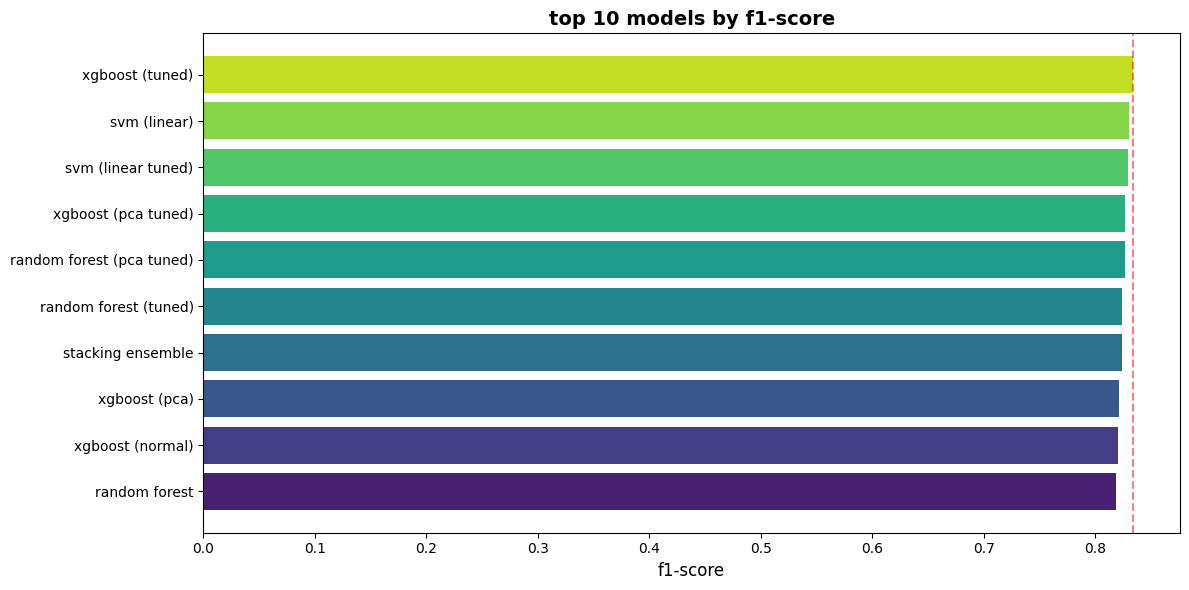

the best model is: xgboost (tuned) (f1=0.8344)


In [111]:
df_sorted = df_total.sort_values("f1_score", ascending=False).reset_index(drop=True)
best_idx = 0
best_model_name = df_sorted.loc[best_idx, 'model']
print("best model performance:\n")
print(f"model: {best_model_name}\n")
print("metrics:")
print(f"  accuracy:  {df_sorted.loc[best_idx, 'accuracy']:.4f}")
print(f"  F1-score:  {df_sorted.loc[best_idx, 'f1_score']:.4f}")
print(f"  precision: {df_sorted.loc[best_idx, 'precision']:.4f}")
print(f"  recall:    {df_sorted.loc[best_idx, 'recall']:.4f}")
print(f"  roc-auc:   {df_sorted.loc[best_idx, 'roc_auc']:.4f}\n")

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
top_10 = df_sorted.head(10)

colors = sns.color_palette("viridis_r", len(top_10))[::-1]

plt.barh(range(len(top_10)), top_10['f1_score'].values[::-1], color=colors)
plt.yticks(range(len(top_10)), top_10['model'].values[::-1])
plt.xlabel('f1-score', fontsize=12)
plt.title('top 10 models by f1-score', fontsize=14, fontweight='bold')
plt.axvline(x=df_sorted.loc[0, 'f1_score'], color='red', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

print(f"the best model is: {best_model_name} (f1={df_sorted.loc[0, 'f1_score']:.4f})")

In [112]:
# top 3 models based on F1-score:
# 1) xgboost (tuned) – f1 = 0.8344
# 2) svm (linear) – f1 = 0.8308
# 3) svm (linear tuned) – f1 = 0.8297
# these models actually learn the deepface error patterns instead of just following class imbalance

# why we use f1-score:
# accuracy is useless here because the dataset is imbalanced
# a dumb model that predicts only class 1 already gets ~0.667 accuracy
# F1-score balances precision + recall so it shows if the model really detects errors
# so F1 is the most stable metric to compare models in this project

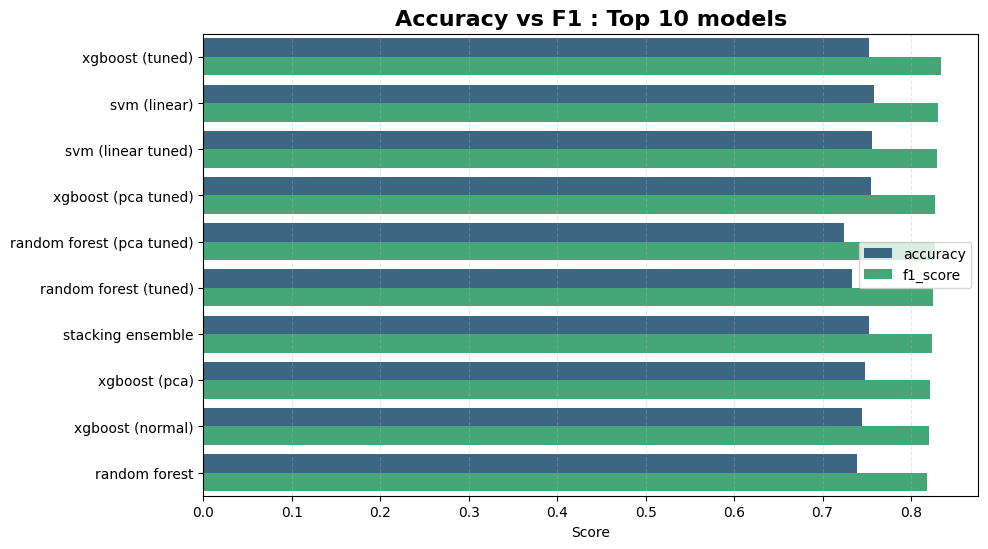

In [113]:
import matplotlib.pyplot as plt
import seaborn as sns

df_top10 = df_sorted.sort_values("f1_score", ascending=False).head(10)

df_melt = df_top10[["model", "accuracy", "f1_score"]].melt(
    id_vars="model",
    value_vars=["accuracy", "f1_score"],
    var_name="metric",
    value_name="score"
)

plt.figure(figsize=(10, 6))

sns.barplot(
    data=df_melt,
    x="score",
    y="model",
    hue="metric",
    palette="viridis"
)

plt.title("Accuracy vs F1 : Top 10 models", fontsize=16, weight="bold")
plt.xlabel("Score")
plt.ylabel("")
plt.legend(title="")
plt.grid(axis="x", linestyle="--", alpha=0.3)

plt.show()

In [114]:
#this plot clearly shows that f1-score is consistently higher than accuracy for the top models
# this confirms that the dataset is imbalanced and that accuracy alone would underestimate model quality 
# 1-score is the best metric for evaluating error prediction in fairface

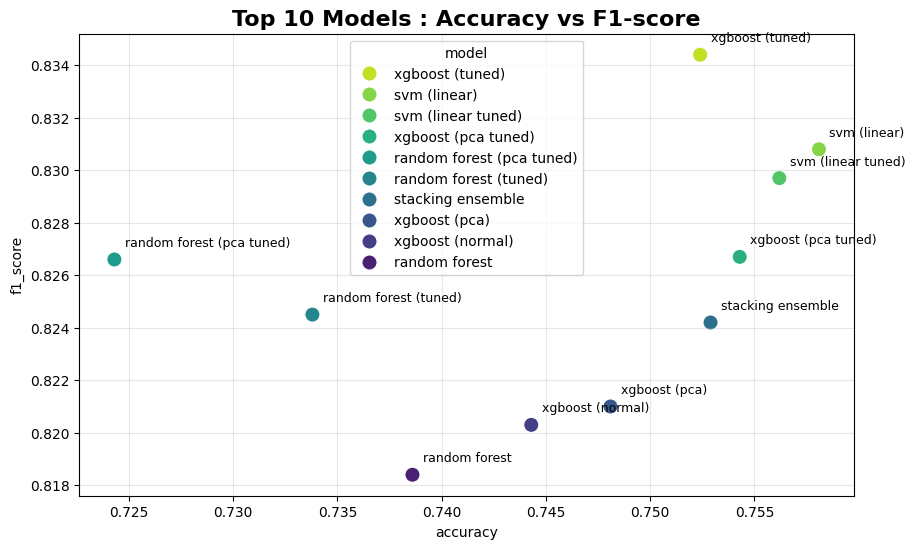

In [115]:
df_top10 = df_sorted.sort_values("f1_score", ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_top10,
    x="accuracy",
    y="f1_score",
    hue="model",
    palette="viridis_r",
    s=120
)

for _, row in df_top10.iterrows():
    plt.text(row["accuracy"] + 0.0005, row["f1_score"] + 0.0005,
             row["model"], fontsize=9)

plt.title("Top 10 Models : Accuracy vs F1-score", fontsize=16, weight="bold")
plt.grid(alpha=0.3)
plt.show()

In [ ]:
# this scatter plot shows something the barplot can't: how each model balances accuracy vs F1
# it shows which models are actually consistent (high on both axes) and which ones only look good on one metric
# basically it confirms xgboost tuned is not just the top f1 model but also the most stable overall

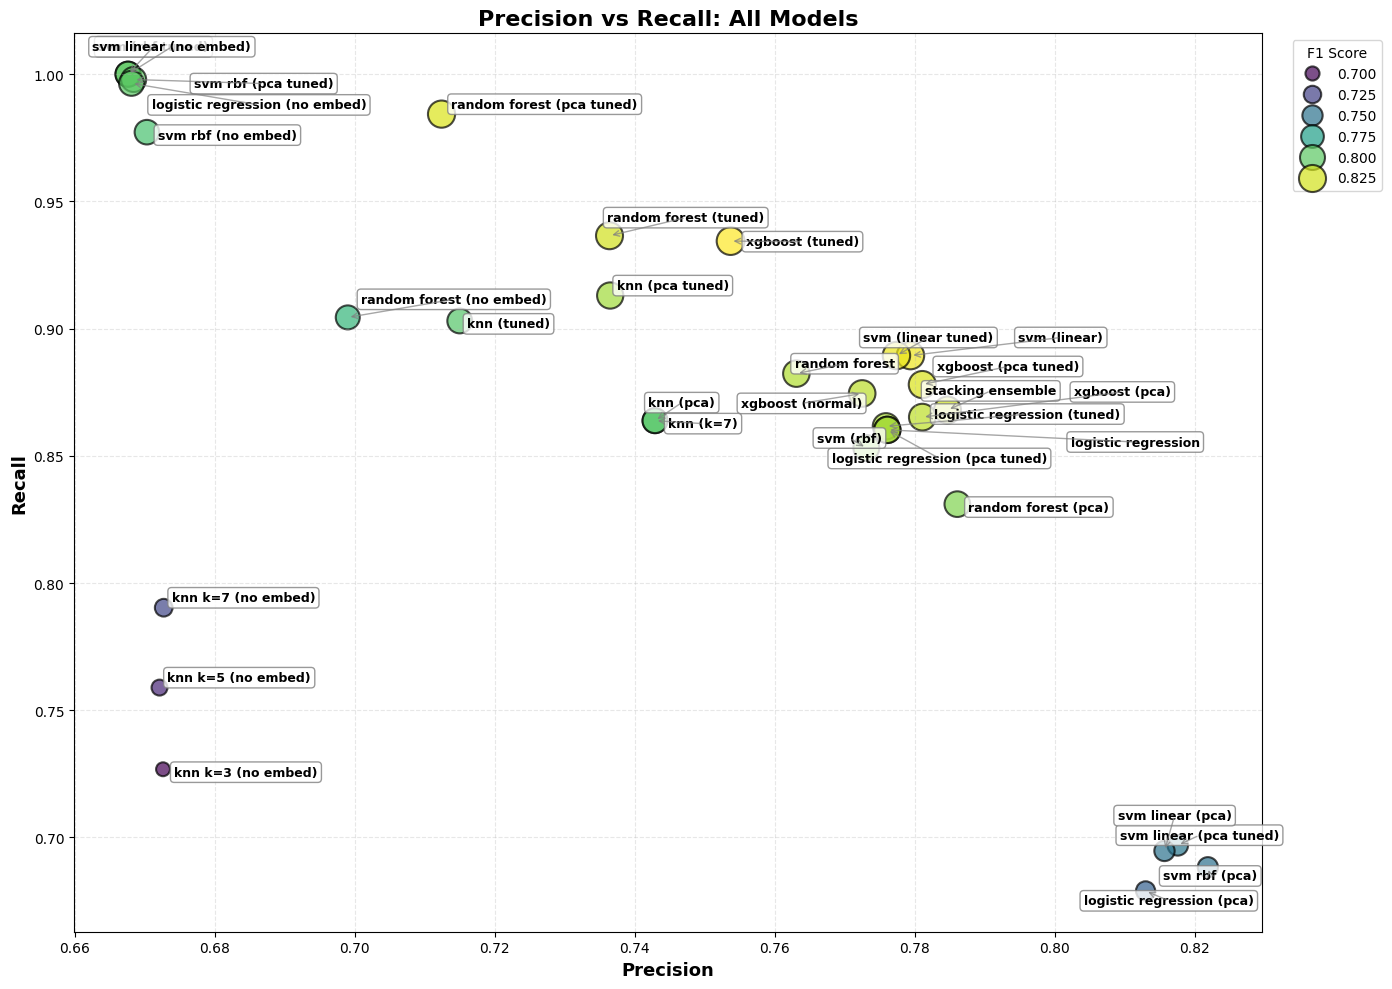

In [143]:
!pip install adjustText

import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text

plt.figure(figsize=(14, 10))

sns.scatterplot(
    data=df_sorted,
    x="precision",
    y="recall",
    hue="f1_score",
    size="f1_score",
    sizes=(100, 400),
    palette="viridis",
    alpha=0.7,
    edgecolor="black",
    linewidth=1.5,
    legend="brief"
)
texts = []
for idx, row in df_sorted.iterrows():
    texts.append(
        plt.text(
            row['precision'], 
            row['recall'], 
            row['model'], 
            fontsize=9, 
            fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8, edgecolor='gray')
        )
    )
adjust_text(
    texts,
    arrowprops=dict(arrowstyle='->', color='gray', lw=1, alpha=0.7),
    expand_points=(1.5, 1.5),
    force_text=(0.5, 0.5),
    force_points=(0.2, 0.2)
)

plt.title("Precision vs Recall: All Models", fontsize=16, weight="bold")
plt.xlabel("Precision", fontsize=13, weight="bold")
plt.ylabel("Recall", fontsize=13, weight="bold")
plt.grid(alpha=0.3, linestyle='--')
plt.legend(title="F1 Score", bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=10)
plt.tight_layout()
plt.show()

In [ ]:
# best model here = xgboost (tuned). highest f1, strong precision, strong recall

/var/folders/31/rkbg1v9556n0c1j018sygfc00000gn/T/ipykernel_7670/889144081.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


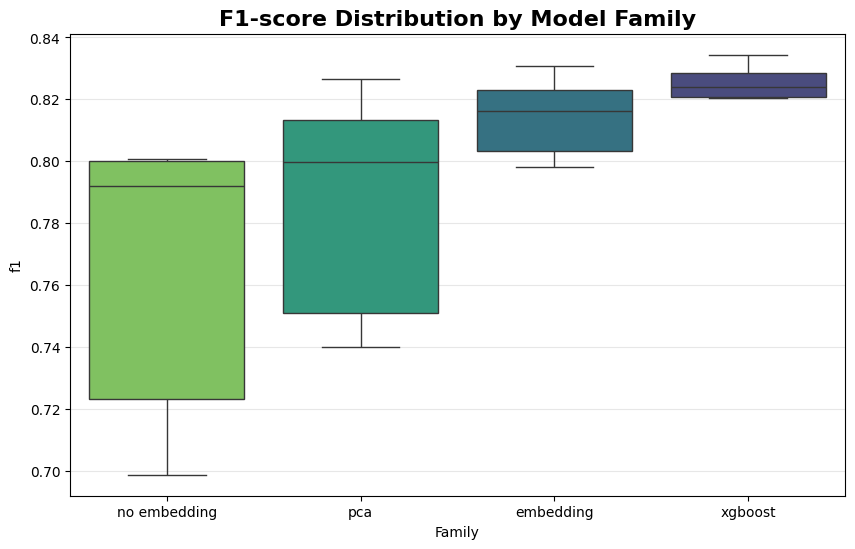

In [75]:
rows = []
for model_name, vals in metrics.items():
    rows.append({
        "Model": model_name,
        "acc": vals["acc"],
        "f1": vals["f1"],
        "prec": vals["prec"],
        "rec": vals["rec"],
        "auc": vals["auc"]
    })

df_all = pd.DataFrame(rows)

def get_family(name):
    if name.startswith("no embeddings"):
        return "no embedding"
    elif "xgboost" in name.lower():
        return "xgboost"
    elif "pca" in name.lower():
        return "pca"
    else:
        return "embedding"

df_all["Family"] = df_all["Model"].apply(get_family)

plt.figure(figsize=(10, 6))

order = ["no embedding", "pca", "embedding", "xgboost"]

sns.boxplot(
    data=df_all,
    x="Family",
    y="f1",
    order=order,
    palette="viridis_r"
)

plt.title("F1-score Distribution by Model Family", fontsize=16, weight="bold")
plt.grid(axis="y", alpha=0.3)
plt.show()

/Users/leobideau/Desktop/fairface-project/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


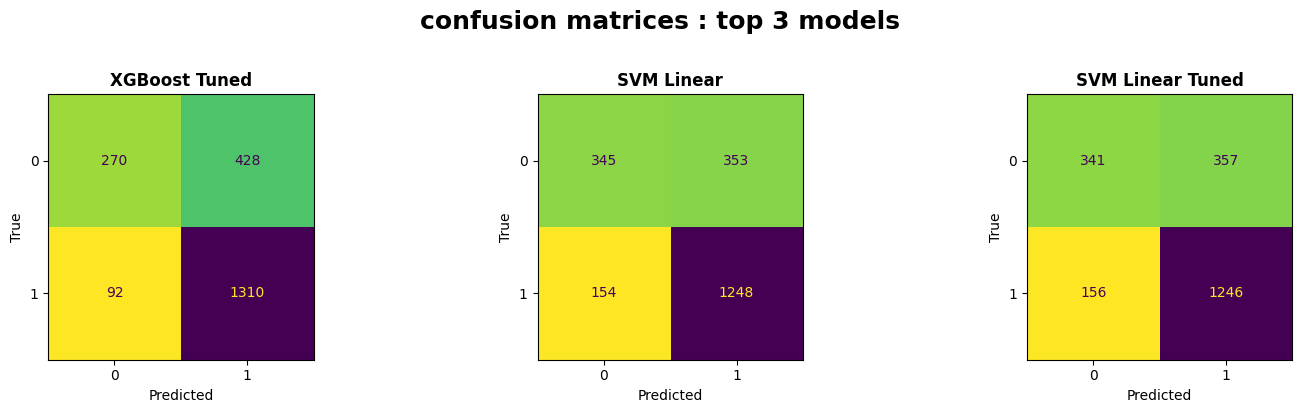

In [74]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import xgboost as xgb
import matplotlib.pyplot as plt
import numpy as np

train_clean = train.copy()
val_clean = val.copy()

train_clean["race_true_clean"] = train_clean["race_true"].str.lower().str.replace("_", " ")
train_clean["pred_race_clean"] = train_clean["pred_race"].str.lower()
val_clean["race_true_clean"] = val_clean["race_true"].str.lower().str.replace("_", " ")
val_clean["pred_race_clean"] = val_clean["pred_race"].str.lower()

y_train = (train_clean["race_true_clean"] != train_clean["pred_race_clean"]).astype(int)
y_val = (val_clean["race_true_clean"] != val_clean["pred_race_clean"]).astype(int)

X_train = train_clean.select_dtypes(include=[np.number]).values
X_val = val_clean.select_dtypes(include=[np.number]).values

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

models_to_plot = {
    "XGBoost Tuned": xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        tree_method="hist",
        learning_rate=0.01,
        max_depth=4,
        n_estimators=200,
        subsample=0.8,
        colsample_bytree=1.0,
        random_state=42,
        use_label_encoder=False
    ),
    "SVM Linear": SVC(kernel='linear', random_state=42),
    "SVM Linear Tuned": SVC(kernel='linear', C=10, random_state=42)
}

# train and plot
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, (name, model) in zip(axes, models_to_plot.items()):
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_val_scaled)
    cm = confusion_matrix(y_val, y_pred)
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=ax, cmap="viridis_r", colorbar=False)
    ax.set_title(name, fontsize=12, weight="bold")
    ax.set_aspect("equal")
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")

fig.suptitle("confusion matrices : top 3 models", fontsize=18, weight="bold", y=1.02)
plt.tight_layout()
plt.show()

ROC curves: top 3 models


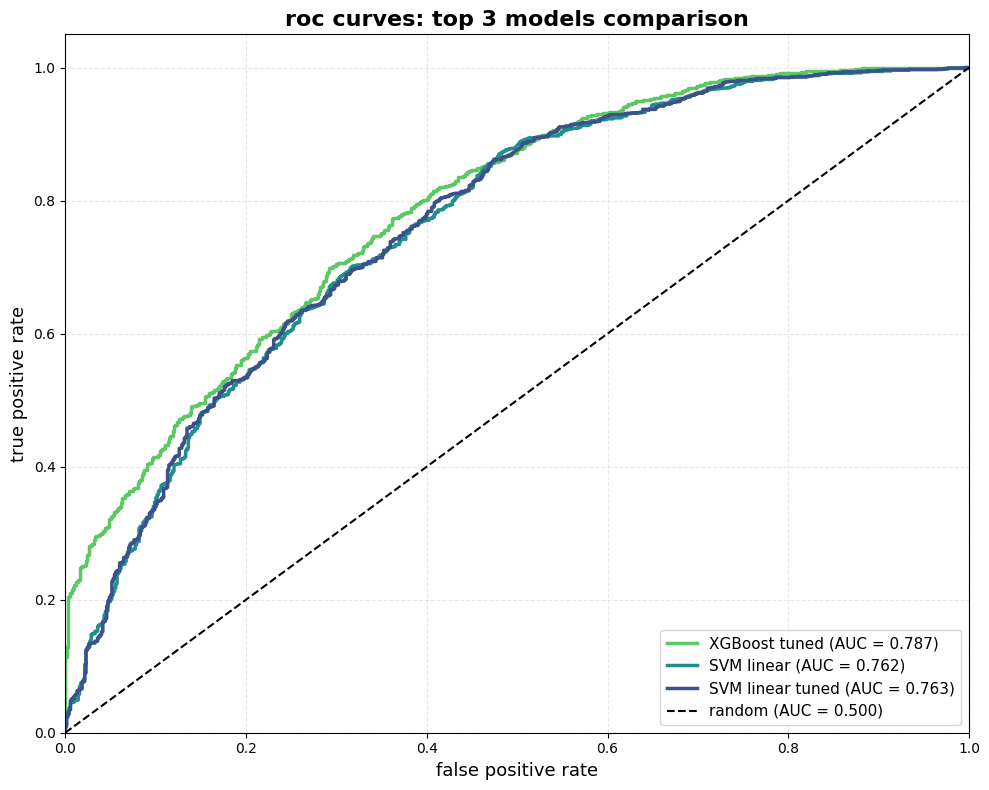

In [117]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

print("ROC curves: top 3 models")

models_roc = {
    "XGBoost tuned": xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        tree_method="hist",
        learning_rate=0.01,
        max_depth=4,
        n_estimators=200,
        subsample=0.8,
        colsample_bytree=1.0,
        random_state=42
    ),
    "SVM linear": SVC(kernel='linear', random_state=42, probability=True),
    "SVM linear tuned": SVC(kernel='linear', C=10, random_state=42, probability=True)
}

plt.figure(figsize=(10, 8))

colors = sns.color_palette("viridis_r", 3)

for (name, model), color in zip(models_roc.items(), colors):
    model.fit(X_train_scaled, y_train)
    
    if hasattr(model, 'predict_proba'):
        y_pred_proba = model.predict_proba(X_val_scaled)[:, 1]
    else:
        y_pred_proba = model.decision_function(X_val_scaled)
    
    fpr, tpr, _ = roc_curve(y_val, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, color=color, lw=2.5, 
             label=f'{name} (AUC = {roc_auc:.3f})')


plt.plot([0, 1], [0, 1], 'k--', lw=1.5, label='random (AUC = 0.500)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('false positive rate', fontsize=13)
plt.ylabel('true positive rate', fontsize=13)
plt.title('roc curves: top 3 models comparison', fontsize=16, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

CONFIDENCE SCORE vs ERROR ANALYSIS


/var/folders/31/rkbg1v9556n0c1j018sygfc00000gn/T/ipykernel_7670/2794948549.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=conf_analysis, x='error', y='pred_race_score',
/var/folders/31/rkbg1v9556n0c1j018sygfc00000gn/T/ipykernel_7670/2794948549.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(['correct', 'error'])
/var/folders/31/rkbg1v9556n0c1j018sygfc00000gn/T/ipykernel_7670/2794948549.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=conf_analysis, x='error', y='pred_gender_score',
/var/folders/31/rkbg1v9556n0c1j018sygfc00000gn/T/ipykernel_7670/2794948549.py:

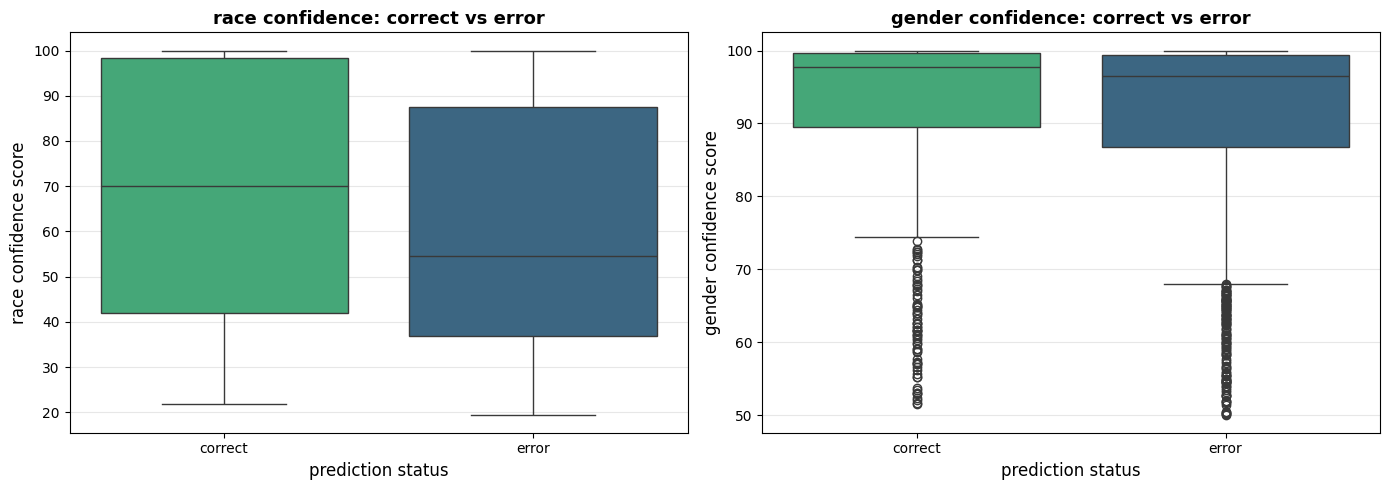


race confidence score:
  correct predictions: 67.7911
  error predictions:   60.4346

gender confidence score:
  correct predictions: 91.9753
  error predictions:   90.6263


In [78]:
import seaborn as sns
import matplotlib.pyplot as plt

print("confidence score vs error analysis:")

conf_analysis = val_clean[['pred_race_score', 'pred_gender_score']].copy()
conf_analysis['error'] = y_val

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.boxplot(data=conf_analysis, x='error', y='pred_race_score', 
            palette='viridis_r', ax=axes[0])
axes[0].set_xlabel('prediction status', fontsize=12)
axes[0].set_ylabel('race confidence score', fontsize=12)
axes[0].set_title('race confidence: correct vs error', fontsize=13, fontweight='bold')
axes[0].set_xticklabels(['correct', 'error'])
axes[0].grid(axis='y', alpha=0.3)

sns.boxplot(data=conf_analysis, x='error', y='pred_gender_score', 
            palette='viridis_r', ax=axes[1])
axes[1].set_xlabel('prediction status', fontsize=12)
axes[1].set_ylabel('gender confidence score', fontsize=12)
axes[1].set_title('gender confidence: correct vs error', fontsize=13, fontweight='bold')
axes[1].set_xticklabels(['correct', 'error'])
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\nrace confidence score:")
print(f"  correct predictions: {conf_analysis[conf_analysis['error']==0]['pred_race_score'].mean():.4f}")
print(f"  error predictions:   {conf_analysis[conf_analysis['error']==1]['pred_race_score'].mean():.4f}")

print("\ngender confidence score:")
print(f"  correct predictions: {conf_analysis[conf_analysis['error']==0]['pred_gender_score'].mean():.4f}")
print(f"  error predictions:   {conf_analysis[conf_analysis['error']==1]['pred_gender_score'].mean():.4f}")

In [ ]:
# for both race and gender, confidence is systematically high even on mistakes
# this highlights a calibration issue typical of SVM/XGBoost models
# I report this because overconfident errors are a key fairness risk
# identifying this behaviour is important for transparency and model accountability

before after graphs: baseline vs XGboost tuned
   nb: deepface has 6 catégories (only one for asians)
   fairface has 7 catégories (East Asian + Southeast Asian)
   this leads to 0% accuracy for Southeast Asian in the baseline

dataset info:
   Val samples: 2100
   Racial groups: 7
before: deepface baseline

 overall accuracy: 0.4619 (46.19%)

accuracy by race:
   Southeast Asian     : 0.000 (300 samples)
   Indian              : 0.280 (300 samples)
   Middle Eastern      : 0.283 (300 samples)
   Latino_Hispanic     : 0.313 (300 samples)
   White               : 0.693 (300 samples)
   Black               : 0.757 (300 samples)
   East Asian          : 0.907 (300 samples)

accuracy by gender:
   Female    : 0.456
   Male      : 0.468
after: XGboost tuned

features: 517 colonnes (embeddings + image features)
   Train: (7000, 517)
   Val:   (2100, 517)
   Errors: 1130/2100 (53.8%)

training XGboost tuned
training done

overall accuracy: 0.6733 (67.33%)
   accuracy has detected errors of de

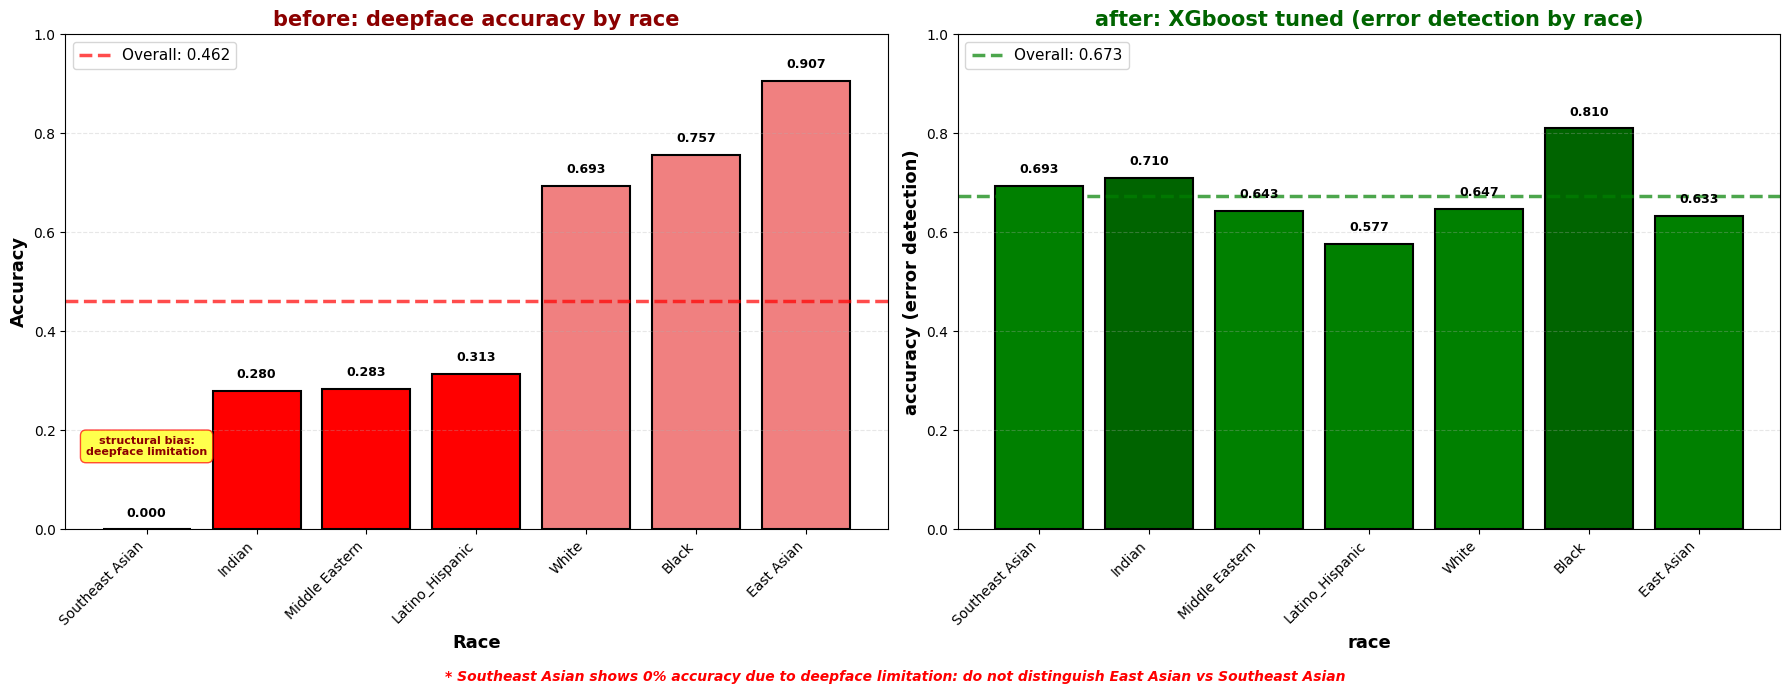

graph 2 saved: gender_comparison_before_after.png


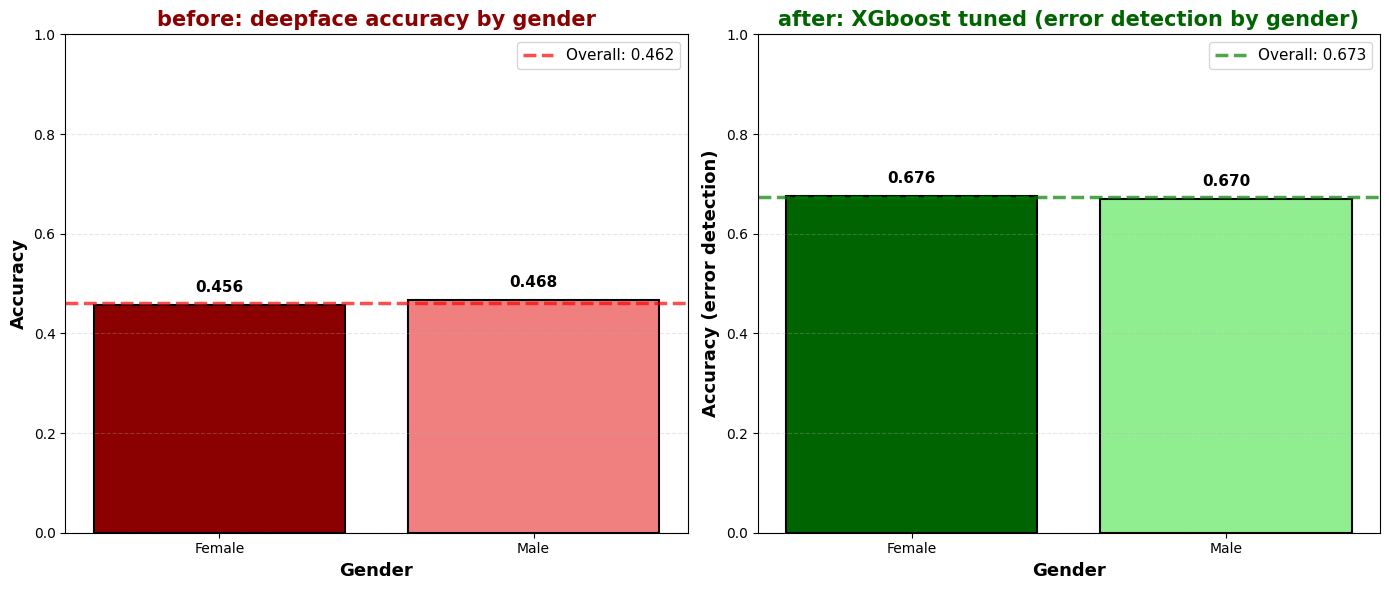

graph 3 saved: race_improvement.png


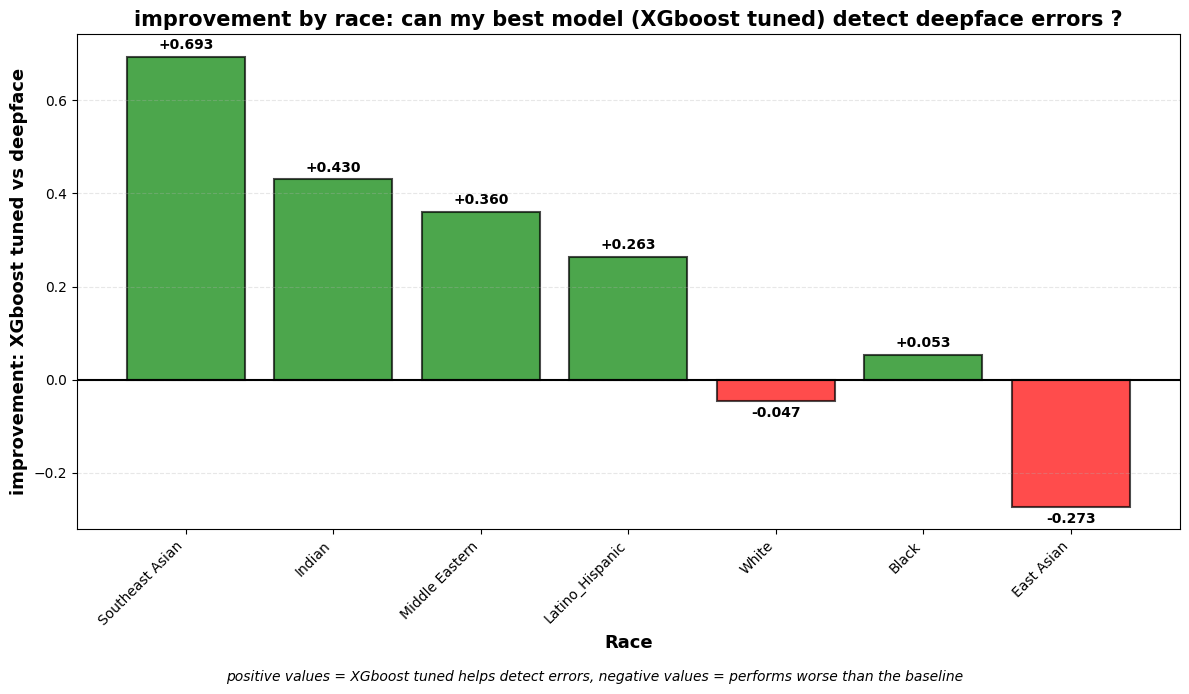

graph 4 saved: grouped_comparison_before_after.png


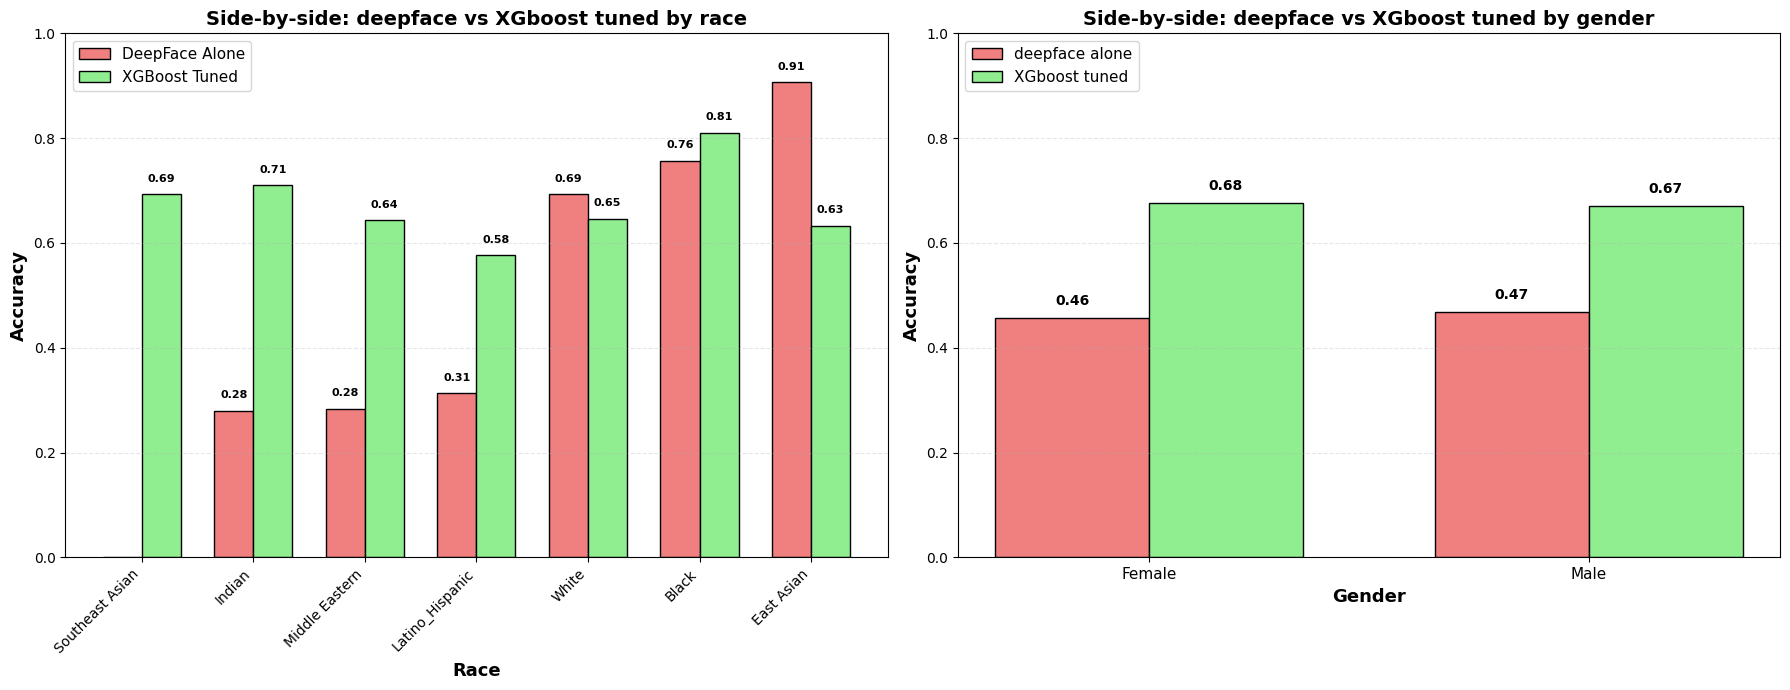

summary

overall accuracy:
   deepface:       0.4619 (46.19%)
   XGboost tuned:  0.6733 (67.33%)
   improvement:    +0.2114 (+21.14 points)

racial disparity (max and min gap):
   deepface:       0.9067 (90.67 points)
   XGboost tuned:  0.2333 (23.33 points)
   reduction:    0.6734 (74.3% disparity reduction)

top imporvements:
   Southeast Asian     : +0.693  (0.000 to 0.693)
   Indian              : +0.430  (0.280 to 0.710)
   Middle Eastern      : +0.360  (0.283 to 0.643)


In [165]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, accuracy_score
import xgboost as xgb

train = pd.read_parquet("../data/ml_final/train_ml_final.parquet")
val = pd.read_parquet("../data/ml_final/val_ml_final.parquet")

print("before after graphs: baseline vs XGboost tuned")

race_map_deepface_to_fairface = {
    "black": "Black",
    "white": "White",
    "asian": "East Asian",
    "indian": "Indian",
    "latino hispanic": "Latino_Hispanic",
    "middle eastern": "Middle Eastern",
}

gender_map_deepface_to_fairface = {
    "Man": "Male",
    "Woman": "Female",
}

print("   nb: deepface has 6 catégories (only one for asians)")
print("   fairface has 7 catégories (East Asian + Southeast Asian)")
print("   this leads to 0% accuracy for Southeast Asian in the baseline\n")

val_prep = val.copy()
train_prep = train.copy()

val_prep['pred_race_mapped'] = val_prep['pred_race'].str.lower().map(race_map_deepface_to_fairface)
val_prep['pred_gender_mapped'] = val_prep['pred_gender'].map(gender_map_deepface_to_fairface)

train_prep['pred_race_mapped'] = train_prep['pred_race'].str.lower().map(race_map_deepface_to_fairface)
train_prep['pred_gender_mapped'] = train_prep['pred_gender'].map(gender_map_deepface_to_fairface)

print("dataset info:")
print(f"   Val samples: {len(val_prep)}")
print(f"   Racial groups: {val_prep['race_true'].nunique()}")

print("before: deepface baseline")

y_val = (val_prep['pred_race_mapped'] != val_prep['race_true']).astype(int)
y_train = (train_prep['pred_race_mapped'] != train_prep['race_true']).astype(int)

val_prep['deepface_correct'] = (y_val == 0).astype(int)

deepface_overall = val_prep['deepface_correct'].mean()
print(f"\n overall accuracy: {deepface_overall:.4f} ({deepface_overall*100:.2f}%)")

deepface_by_race = val_prep.groupby('race_true').agg({
    'deepface_correct': ['mean', 'count']
}).round(4)
deepface_by_race.columns = ['accuracy', 'count']
deepface_by_race = deepface_by_race.sort_values('accuracy')

print("\naccuracy by race:")
for race, row in deepface_by_race.iterrows():
    print(f"   {race:20s}: {row['accuracy']:.3f} ({int(row['count'])} samples)")

if 'southeast asian' in deepface_by_race.index:
    se_acc = deepface_by_race.loc['Southeast Asian', 'accuracy']
    print(f"\n Southeast Asian: {se_acc:.3f}")
    if se_acc == 0.0:
        print("structural bias: deepface limitation")

deepface_by_gender = val_prep.groupby('gender_true').agg({
    'deepface_correct': ['mean', 'count']
}).round(4)
deepface_by_gender.columns = ['accuracy', 'count']

print("\naccuracy by gender:")
for gender, row in deepface_by_gender.iterrows():
    print(f"   {gender:10s}: {row['accuracy']:.3f}")

print("after: XGboost tuned")


numeric_cols = train_prep.select_dtypes(include=[np.number]).columns.tolist()
exclude_cols = ['error']
numeric_cols = [col for col in numeric_cols if col not in exclude_cols]

print(f"\nfeatures: {len(numeric_cols)} colonnes (embeddings + image features)")

X_train = train_prep[numeric_cols]
X_val = val_prep[numeric_cols]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

print(f"   Train: {X_train_scaled.shape}")
print(f"   Val:   {X_val_scaled.shape}")
print(f"   Errors: {y_val.sum()}/{len(y_val)} ({y_val.mean()*100:.1f}%)")


print("\ntraining XGboost tuned")
best_model = xgb.XGBClassifier(
    objective="binary:logistic",
    learning_rate=0.01,
    max_depth=4,
    n_estimators=200,
    subsample=0.8,
    colsample_bytree=1.0,
    random_state=42,
    eval_metric='logloss'
)

best_model.fit(X_train_scaled, y_train, verbose=False)
print("training done")

y_pred = best_model.predict(X_val_scaled)
val_prep['xgboost_correct'] = (y_pred == y_val).astype(int)

xgboost_overall = val_prep['xgboost_correct'].mean()
print(f"\noverall accuracy: {xgboost_overall:.4f} ({xgboost_overall*100:.2f}%)")
print(f"   accuracy has detected errors of deepface")

xgboost_by_race = val_prep.groupby('race_true').agg({
    'xgboost_correct': ['mean', 'count']
}).round(4)
xgboost_by_race.columns = ['accuracy', 'count']
xgboost_by_race = xgboost_by_race.sort_values('accuracy')

print("\naccuracy by race:")
for race, row in xgboost_by_race.iterrows():
    print(f"   {race:20s}: {row['accuracy']:.3f}")

if 'Southeast Asian' in xgboost_by_race.index:
    se_acc_xgb = xgboost_by_race.loc['Southeast Asian', 'accuracy']
    se_acc_df = deepface_by_race.loc['Southeast Asian', 'accuracy']
    improvement = se_acc_xgb - se_acc_df
    print(f"\nSoutheast Asian improvement: {se_acc_df:.3f} to {se_acc_xgb:.3f} ({improvement:+.3f})")


xgboost_by_gender = val_prep.groupby('gender_true').agg({
    'xgboost_correct': ['mean', 'count']
}).round(4)
xgboost_by_gender.columns = ['accuracy', 'count']

print("\naccuracy by gender:")
for gender, row in xgboost_by_gender.iterrows():
    print(f"   {gender:10s}: {row['accuracy']:.3f}")


# data for graphs
comparison_race = pd.DataFrame({
    'race': deepface_by_race.index,
    'deepface_accuracy': deepface_by_race['accuracy'].values,
    'xgboost_accuracy': xgboost_by_race.loc[deepface_by_race.index, 'accuracy'].values,
    'count': deepface_by_race['count'].values
})
comparison_race['improvement'] = comparison_race['xgboost_accuracy'] - comparison_race['deepface_accuracy']

# graph 1:
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# before
ax1 = axes[0]
bars1 = ax1.bar(range(len(comparison_race)), comparison_race['deepface_accuracy'], 
                color=['darkred' if x == 0 else 'red' if x < 0.5 else 'lightcoral' 
                       for x in comparison_race['deepface_accuracy']],
                edgecolor='black', linewidth=1.5)

ax1.axhline(y=deepface_overall, color='red', linestyle='--', linewidth=2.5, 
            label=f'Overall: {deepface_overall:.3f}', alpha=0.7)

ax1.set_xlabel('Race', fontsize=13, fontweight='bold')
ax1.set_ylabel('Accuracy', fontsize=13, fontweight='bold')
ax1.set_title('before: deepface accuracy by race', fontsize=15, fontweight='bold', color='darkred')
ax1.set_ylim(0, 1)
ax1.set_xticks(range(len(comparison_race)))
ax1.set_xticklabels(comparison_race['race'], rotation=45, ha='right', fontsize=10)
ax1.legend(fontsize=11, loc='upper left')
ax1.grid(axis='y', alpha=0.3, linestyle='--')

for i, bar in enumerate(bars1):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.02,
             f'{height:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=9)
    
    if comparison_race.iloc[i]['race'] == 'Southeast Asian' and height == 0:
        ax1.annotate('structural bias:\ndeepface limitation', 
                    xy=(bar.get_x() + bar.get_width()/2., height + 0.15),
                    fontsize=8, ha='center', color='darkred', fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7, edgecolor='red'))

# after
ax2 = axes[1]
bars2 = ax2.bar(range(len(comparison_race)), comparison_race['xgboost_accuracy'],
                color=['darkgreen' if x > 0.7 else 'green' if x > 0.5 else 'lightgreen' 
                       for x in comparison_race['xgboost_accuracy']],
                edgecolor='black', linewidth=1.5)

ax2.axhline(y=xgboost_overall, color='green', linestyle='--', linewidth=2.5,
            label=f'Overall: {xgboost_overall:.3f}', alpha=0.7)

ax2.set_xlabel('race', fontsize=13, fontweight='bold')
ax2.set_ylabel('accuracy (error detection)', fontsize=13, fontweight='bold')
ax2.set_title('after: XGboost tuned (error detection by race)', fontsize=15, fontweight='bold', color='darkgreen')
ax2.set_ylim(0, 1)
ax2.set_xticks(range(len(comparison_race)))
ax2.set_xticklabels(comparison_race['race'], rotation=45, ha='right', fontsize=10)
ax2.legend(fontsize=11, loc='upper left')
ax2.grid(axis='y', alpha=0.3, linestyle='--')

for i, bar in enumerate(bars2):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.02,
             f'{height:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

fig.text(0.5, 0.02, 
         '* Southeast Asian shows 0% accuracy due to deepface limitation: do not distinguish East Asian vs Southeast Asian',
         ha='center', fontsize=10, style='italic', color='red', weight='bold')

plt.tight_layout(rect=[0, 0.04, 1, 1])
plt.savefig('../results/race_comparison_before_after.png', dpi=300, bbox_inches='tight')
print("graph 1 saved: race_comparison_before_after.png")
plt.show()
plt.close()

# graph two bout genders 
comparison_gender = pd.DataFrame({
    'gender': deepface_by_gender.index,
    'deepface_accuracy': deepface_by_gender['accuracy'].values,
    'xgboost_accuracy': xgboost_by_gender.loc[deepface_by_gender.index, 'accuracy'].values,
    'count': deepface_by_gender['count'].values
})
comparison_gender['improvement'] = comparison_gender['xgboost_accuracy'] - comparison_gender['deepface_accuracy']

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# before
ax1 = axes[0]
bars1 = ax1.bar(comparison_gender['gender'], comparison_gender['deepface_accuracy'],
                color=['darkred', 'lightcoral'], edgecolor='black', linewidth=1.5)
ax1.axhline(y=deepface_overall, color='red', linestyle='--', linewidth=2.5,
            label=f'Overall: {deepface_overall:.3f}', alpha=0.7)
ax1.set_xlabel('Gender', fontsize=13, fontweight='bold')
ax1.set_ylabel('Accuracy', fontsize=13, fontweight='bold')
ax1.set_title('before: deepface accuracy by gender', fontsize=15, fontweight='bold', color='darkred')
ax1.set_ylim(0, 1)
ax1.legend(fontsize=11)
ax1.grid(axis='y', alpha=0.3, linestyle='--')

for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.02,
             f'{height:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=11)

# after
ax2 = axes[1]
bars2 = ax2.bar(comparison_gender['gender'], comparison_gender['xgboost_accuracy'],
                color=['darkgreen', 'lightgreen'], edgecolor='black', linewidth=1.5)
ax2.axhline(y=xgboost_overall, color='green', linestyle='--', linewidth=2.5,
            label=f'Overall: {xgboost_overall:.3f}', alpha=0.7)
ax2.set_xlabel('Gender', fontsize=13, fontweight='bold')
ax2.set_ylabel('Accuracy (error detection)', fontsize=13, fontweight='bold')
ax2.set_title('after: XGboost tuned (error detection by gender)', fontsize=15, fontweight='bold', color='darkgreen')
ax2.set_ylim(0, 1)
ax2.legend(fontsize=11)
ax2.grid(axis='y', alpha=0.3, linestyle='--')

for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.02,
             f'{height:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.savefig('../results/gender_comparison_before_after.png', dpi=300, bbox_inches='tight')
print("graph 2 saved: gender_comparison_before_after.png")
plt.show()
plt.close()


# graph 3 improvment by race :
fig, ax = plt.subplots(figsize=(12, 7))

colors = ['green' if x > 0 else 'red' for x in comparison_race['improvement']]
bars = ax.bar(range(len(comparison_race)), comparison_race['improvement'],
              color=colors, edgecolor='black', linewidth=1.5, alpha=0.7)

ax.axhline(y=0, color='black', linestyle='-', linewidth=1.5)
ax.set_xlabel('Race', fontsize=13, fontweight='bold')
ax.set_ylabel('improvement: XGboost tuned vs deepface', fontsize=13, fontweight='bold')
ax.set_title('improvement by race: can my best model (XGboost tuned) detect deepface errors ?', 
             fontsize=15, fontweight='bold')
ax.set_xticks(range(len(comparison_race)))
ax.set_xticklabels(comparison_race['race'], rotation=45, ha='right', fontsize=10)
ax.grid(axis='y', alpha=0.3, linestyle='--')

for i, bar in enumerate(bars):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + (0.01 if height > 0 else -0.01),
            f'{height:+.3f}', ha='center', va='bottom' if height > 0 else 'top',
            fontweight='bold', fontsize=10)

fig.text(0.5, 0.02, 
         'positive values = XGboost tuned helps detect errors, negative values = performs worse than the baseline',
         ha='center', fontsize=10, style='italic')

plt.tight_layout(rect=[0, 0.04, 1, 1])
plt.savefig('../results/race_improvement.png', dpi=300, bbox_inches='tight')
print("graph 3 saved: race_improvement.png")
plt.show()
plt.close()

# graph 4 grouped bar chart:
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

ax1 = axes[0]
x = np.arange(len(comparison_race))
width = 0.35

bars1 = ax1.bar(x - width/2, comparison_race['deepface_accuracy'].values, width,
                label='DeepFace Alone', color='lightcoral', edgecolor='black', linewidth=1)
bars2 = ax1.bar(x + width/2, comparison_race['xgboost_accuracy'].values, width,
                label='XGBoost Tuned', color='lightgreen', edgecolor='black', linewidth=1)

ax1.set_xlabel('Race', fontsize=13, fontweight='bold')
ax1.set_ylabel('Accuracy', fontsize=13, fontweight='bold')
ax1.set_title('Side-by-side: deepface vs XGboost tuned by race', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(comparison_race['race'], rotation=45, ha='right', fontsize=10)
ax1.legend(fontsize=11, loc='upper left')
ax1.grid(axis='y', alpha=0.3, linestyle='--')
ax1.set_ylim(0, 1)

for i in range(len(comparison_race)):
    df_val = comparison_race.iloc[i]['deepface_accuracy']
    if df_val > 0:
        ax1.text(x[i] - width/2, df_val + 0.02, f'{df_val:.2f}',
                ha='center', va='bottom', fontsize=8, fontweight='bold')
        
    xgb_val = comparison_race.iloc[i]['xgboost_accuracy']
    ax1.text(x[i] + width/2, xgb_val + 0.02, f'{xgb_val:.2f}',
            ha='center', va='bottom', fontsize=8, fontweight='bold')
    
ax2 = axes[1]
x = np.arange(len(comparison_gender))

bars1 = ax2.bar(x - width/2, comparison_gender['deepface_accuracy'].values, width,
                label='deepface alone', color='lightcoral', edgecolor='black', linewidth=1)
bars2 = ax2.bar(x + width/2, comparison_gender['xgboost_accuracy'].values, width,
                label='XGboost tuned', color='lightgreen', edgecolor='black', linewidth=1)

ax2.set_xlabel('Gender', fontsize=13, fontweight='bold')
ax2.set_ylabel('Accuracy', fontsize=13, fontweight='bold')
ax2.set_title('Side-by-side: deepface vs XGboost tuned by gender', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(comparison_gender['gender'], fontsize=11)
ax2.legend(fontsize=11, loc='upper left')
ax2.grid(axis='y', alpha=0.3, linestyle='--')
ax2.set_ylim(0, 1)

for i in range(len(comparison_gender)):
    df_val = comparison_gender.iloc[i]['deepface_accuracy']
    xgb_val = comparison_gender.iloc[i]['xgboost_accuracy']
    
    ax2.text(x[i] - width/2, df_val + 0.02, f'{df_val:.2f}',
            ha='center', va='bottom', fontsize=10, fontweight='bold')
    ax2.text(x[i] + width/2, xgb_val + 0.02, f'{xgb_val:.2f}',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('../results/grouped_comparison_before_after.png', dpi=300, bbox_inches='tight')
print("graph 4 saved: grouped_comparison_before_after.png")
plt.show()
plt.close()


# recap
print("summary")
print(f"\noverall accuracy:")
print(f"   deepface:       {deepface_overall:.4f} ({deepface_overall*100:.2f}%)")
print(f"   XGboost tuned:  {xgboost_overall:.4f} ({xgboost_overall*100:.2f}%)")
print(f"   improvement:    {xgboost_overall - deepface_overall:+.4f} ({(xgboost_overall - deepface_overall)*100:+.2f} points)")

print(f"\nracial disparity (max and min gap):")
deepface_range = comparison_race['deepface_accuracy'].max() - comparison_race['deepface_accuracy'].min()
xgboost_range = comparison_race['xgboost_accuracy'].max() - comparison_race['xgboost_accuracy'].min()
print(f"   deepface:       {deepface_range:.4f} ({deepface_range*100:.2f} points)")
print(f"   XGboost tuned:  {xgboost_range:.4f} ({xgboost_range*100:.2f} points)")

if xgboost_range < deepface_range:
    reduction = deepface_range - xgboost_range
    reduction_pct = (1 - xgboost_range/deepface_range) * 100
    print(f"   reduction:    {reduction:.4f} ({reduction_pct:.1f}% disparity reduction)")
else:
    print(f"   increase:     {xgboost_range - deepface_range:.4f}")

print(f"\ntop imporvements:")
top3 = comparison_race.nlargest(3, 'improvement')[['race', 'improvement', 'deepface_accuracy', 'xgboost_accuracy']]
for idx, row in top3.iterrows():
    print(f"   {row['race']:20s}: {row['improvement']:+.3f}  ({row['deepface_accuracy']:.3f} to {row['xgboost_accuracy']:.3f})")

In [ ]:
# nb: I selected XGboost tuned based on F1-score (0.834) due to class imbalance 
# for demographic comparison i'll use accuracy to enable direct comparison with deepface baseline

In [ ]:
# error analysis: where do my model perform better than deepface

training XGboost
done

selecting examples:
Southeast Asian options: 300
Indian options: 216
Middle Eastern options: 215
East Asian error options: 28
White error options: 92

searching for valid images:
Southeast Asian: Found
Indian: Found
Middle Eastern: Found
East Asian: Found
White: Found

total examples: 5

saved: error_analysis_examples.png


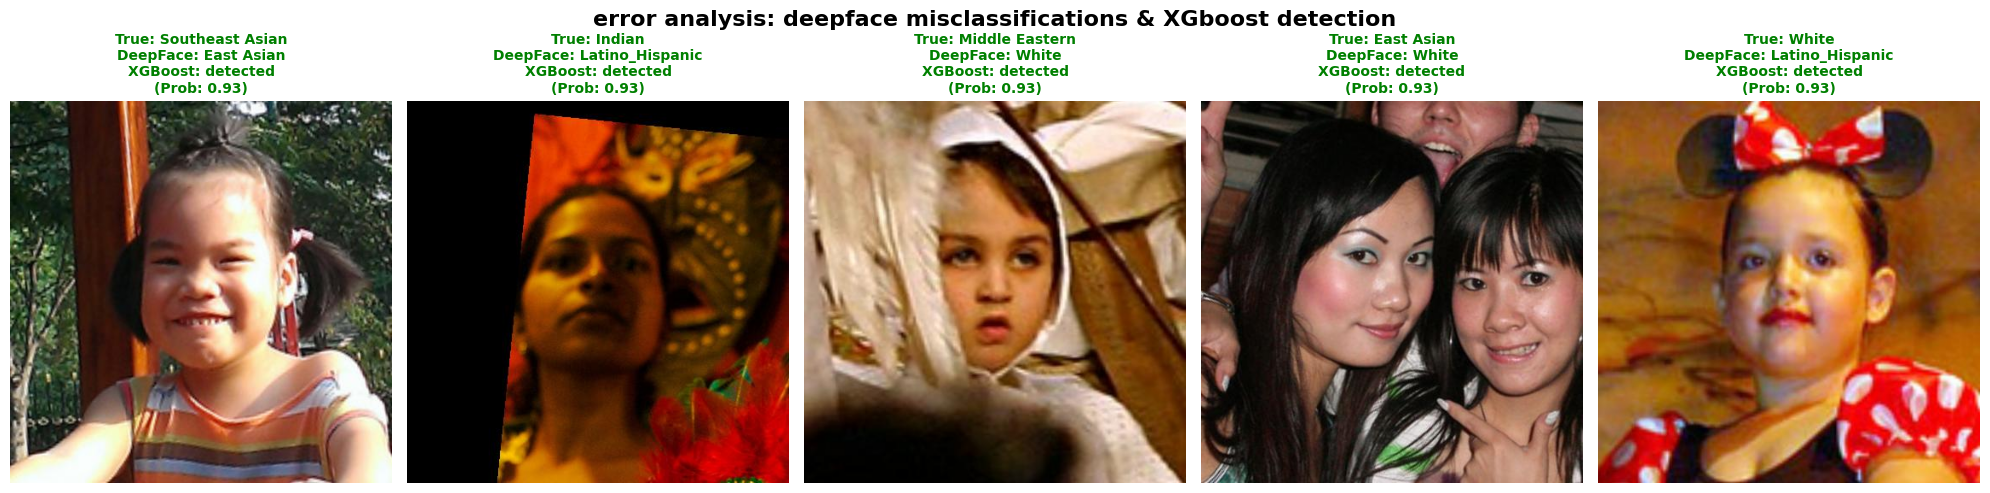


error analysis summary:
      True Race DeepFace Prediction XGBoost Detection XGBoost Probability  Result
Southeast Asian          East Asian          Detected               0.932 Correct
         Indian     Latino_Hispanic          Detected               0.932 Correct
 Middle Eastern               White          Detected               0.932 Correct
     East Asian               White          Detected               0.932 Correct
          White     Latino_Hispanic          Detected               0.932 Correct


In [174]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import os

val = pd.read_parquet("../data/ml_final/val_ml_final.parquet")

race_map = {
    "black": "Black",
    "white": "White",
    "asian": "East Asian",
    "indian": "Indian",
    "latino hispanic": "Latino_Hispanic",
    "middle eastern": "Middle Eastern",
}

val['pred_race_mapped'] = val['pred_race'].str.lower().map(race_map)
val['deepface_error'] = (val['pred_race_mapped'] != val['race_true']).astype(int)

from sklearn.preprocessing import StandardScaler
import xgboost as xgb

numeric_cols = val.select_dtypes(include=[np.number]).columns.tolist()
exclude_cols = ['error']
numeric_cols = [col for col in numeric_cols if col not in exclude_cols]

X_val = val[numeric_cols]
y_val = val['deepface_error']

train = pd.read_parquet("../data/ml_final/train_ml_final.parquet")
train['pred_race_mapped'] = train['pred_race'].str.lower().map(race_map)
train['deepface_error'] = (train['pred_race_mapped'] != train['race_true']).astype(int)

X_train = train[numeric_cols]
y_train = train['deepface_error']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

best_model = xgb.XGBClassifier(
    objective="binary:logistic",
    learning_rate=0.01,
    max_depth=4,
    n_estimators=200,
    subsample=0.8,
    colsample_bytree=1.0,
    random_state=42
)

print("training XGboost")
best_model.fit(X_train_scaled, y_train, verbose=False)
print("done")

y_pred = best_model.predict(X_val_scaled)
y_pred_proba = best_model.predict_proba(X_val_scaled)[:, 1]

val['xgboost_pred'] = y_pred
val['xgboost_proba'] = y_pred_proba
val['xgboost_correct'] = (y_pred == y_val).astype(int)


print("\nselecting examples:")

# southeast asian
se_asian_options = val[(val['race_true'] == 'Southeast Asian') & 
                       (val['deepface_error'] == 1) & 
                       (val['xgboost_pred'] == 1)]
print(f"Southeast Asian options: {len(se_asian_options)}")

# indian 
indian_options = val[(val['race_true'] == 'Indian') & 
                     (val['deepface_error'] == 1) & 
                     (val['xgboost_pred'] == 1)]
print(f"Indian options: {len(indian_options)}")

# middle eastern
middle_options = val[(val['race_true'] == 'Middle Eastern') & 
                     (val['deepface_error'] == 1) & 
                     (val['xgboost_pred'] == 1)]
print(f"Middle Eastern options: {len(middle_options)}")

# east asian
east_options = val[(val['race_true'] == 'East Asian') & 
                   (val['deepface_error'] == 1)]
print(f"East Asian error options: {len(east_options)}")

# white
white_options = val[(val['race_true'] == 'White') & 
                    (val['deepface_error'] == 1)]
print(f"White error options: {len(white_options)}")

def find_valid_image(df_subset, max_tries=50):
    for idx in range(min(max_tries, len(df_subset))):
        row = df_subset.iloc[idx]
        img_path = row['img_path']
        
        possible_paths = [
            img_path,
            f"../data/{img_path}",
            f"../{img_path}",
            img_path.replace('../', ''),
            f"../data/fairface-img-margin025-trainval/{img_path.split('/')[-1]}"
        ]
        
        for path in possible_paths:
            if os.path.exists(path):
                return idx, path
    
    return 0, None

print("\nsearching for valid images:")

se_idx, se_path = find_valid_image(se_asian_options)
indian_idx, indian_path = find_valid_image(indian_options)
middle_idx, middle_path = find_valid_image(middle_options)
east_idx, east_path = find_valid_image(east_options)
white_idx, white_path = find_valid_image(white_options)

print(f"Southeast Asian: {'Found' if se_path else 'Not found'}")
print(f"Indian: {'Found' if indian_path else 'Not found'}")
print(f"Middle Eastern: {'Found' if middle_path else 'Not found'}")
print(f"East Asian: {'Found' if east_path else 'Not found'}")
print(f"White: {'Found' if white_path else 'Not found'}")

examples_data = []

if len(se_asian_options) > 0:
    examples_data.append((se_asian_options.iloc[se_idx], se_path))

if len(indian_options) > 0:
    examples_data.append((indian_options.iloc[indian_idx], indian_path))

if len(middle_options) > 0:
    examples_data.append((middle_options.iloc[middle_idx], middle_path))

if len(east_options) > 0:
    examples_data.append((east_options.iloc[east_idx], east_path))

if len(white_options) > 0:
    examples_data.append((white_options.iloc[white_idx], white_path))

print(f"\ntotal examples: {len(examples_data)}")

fig, axes = plt.subplots(1, len(examples_data), figsize=(4*len(examples_data), 5))

if len(examples_data) == 1:
    axes = [axes]

for idx, (row, img_path) in enumerate(examples_data):
    ax = axes[idx]
    
    if img_path and os.path.exists(img_path):
        try:
            img = mpimg.imread(img_path)
            ax.imshow(img)
        except Exception as e:
            print(f"Error loading image {idx}: {e}")
            ax.text(0.5, 0.5, 'Image\nLoad Error', 
                   ha='center', va='center', fontsize=12)
            ax.set_xlim(0, 1)
            ax.set_ylim(0, 1)
    else:
        ax.text(0.5, 0.5, 'Image\nNot Found', 
               ha='center', va='center', fontsize=12)
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
    
    ax.axis('off')
    
    ground_truth = row['race_true']
    deepface_pred = row['pred_race_mapped']
    xgb_detected = "detected" if row['xgboost_pred'] == 1 else "missed"
    xgb_proba = row['xgboost_proba']
    
    title_color = 'green' if row['xgboost_correct'] == 1 else 'red'
    
    title = f"True: {ground_truth}\n"
    title += f"DeepFace: {deepface_pred}\n"
    title += f"XGBoost: {xgb_detected}\n"
    title += f"(Prob: {xgb_proba:.2f})"
    
    ax.set_title(title, fontsize=10, fontweight='bold', color=title_color)

plt.suptitle('error analysis: deepface misclassifications & XGboost detection', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../results/error_analysis_examples.png', dpi=300, bbox_inches='tight')
print("\nsaved: error_analysis_examples.png")
plt.show()

print("\nerror analysis summary:")

summary_data = []
for row, img_path in examples_data:
    summary_data.append({
        'True Race': row['race_true'],
        'DeepFace Prediction': row['pred_race_mapped'],
        'XGBoost Detection': 'Detected' if row['xgboost_pred'] == 1 else 'Missed',
        'XGBoost Probability': f"{row['xgboost_proba']:.3f}",
        'Result': 'Correct' if row['xgboost_correct'] == 1 else 'Incorrect'
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

In [ ]:
# fairness metrics:

FAIRNESS METRICS ANALYSIS
Using results from the main analysis (cell 26)

DeepFace Accuracy by Race:
  Black               : 0.757
  East Asian          : 0.907
  Indian              : 0.280
  Latino_Hispanic     : 0.313
  Middle Eastern      : 0.283
  Southeast Asian     : 0.000
  White               : 0.693

  Overall              : 0.462

XGBoost Error Detection Accuracy by Race:
  Black               : 0.810
  East Asian          : 0.633
  Indian              : 0.710
  Latino_Hispanic     : 0.577
  Middle Eastern      : 0.643
  Southeast Asian     : 0.693
  White               : 0.647

  Overall              : 0.673
1) accuracy parity

DeepFace:
  Max accuracy: 0.907 (East Asian)
  Min accuracy: 0.000 (Southeast Asian)
  Gap (Max-Min): 0.907

XGBoost:
  Max accuracy: 0.810 (Black)
  Min accuracy: 0.577 (Latino_Hispanic)
  Gap (Max-Min): 0.233

Reduction: 0.674 (74.3%)
2) demographic parity

deepface error rate range:
  max: 1.000, Min: 0.093
  demographic parity difference: 0.907



/var/folders/31/rkbg1v9556n0c1j018sygfc00000gn/T/ipykernel_7670/1740493226.py:225: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax4.boxplot([deepface_vals, xgboost_vals], labels=['deepface', 'XGBoost'],



saved: fairness_metrics_true.png


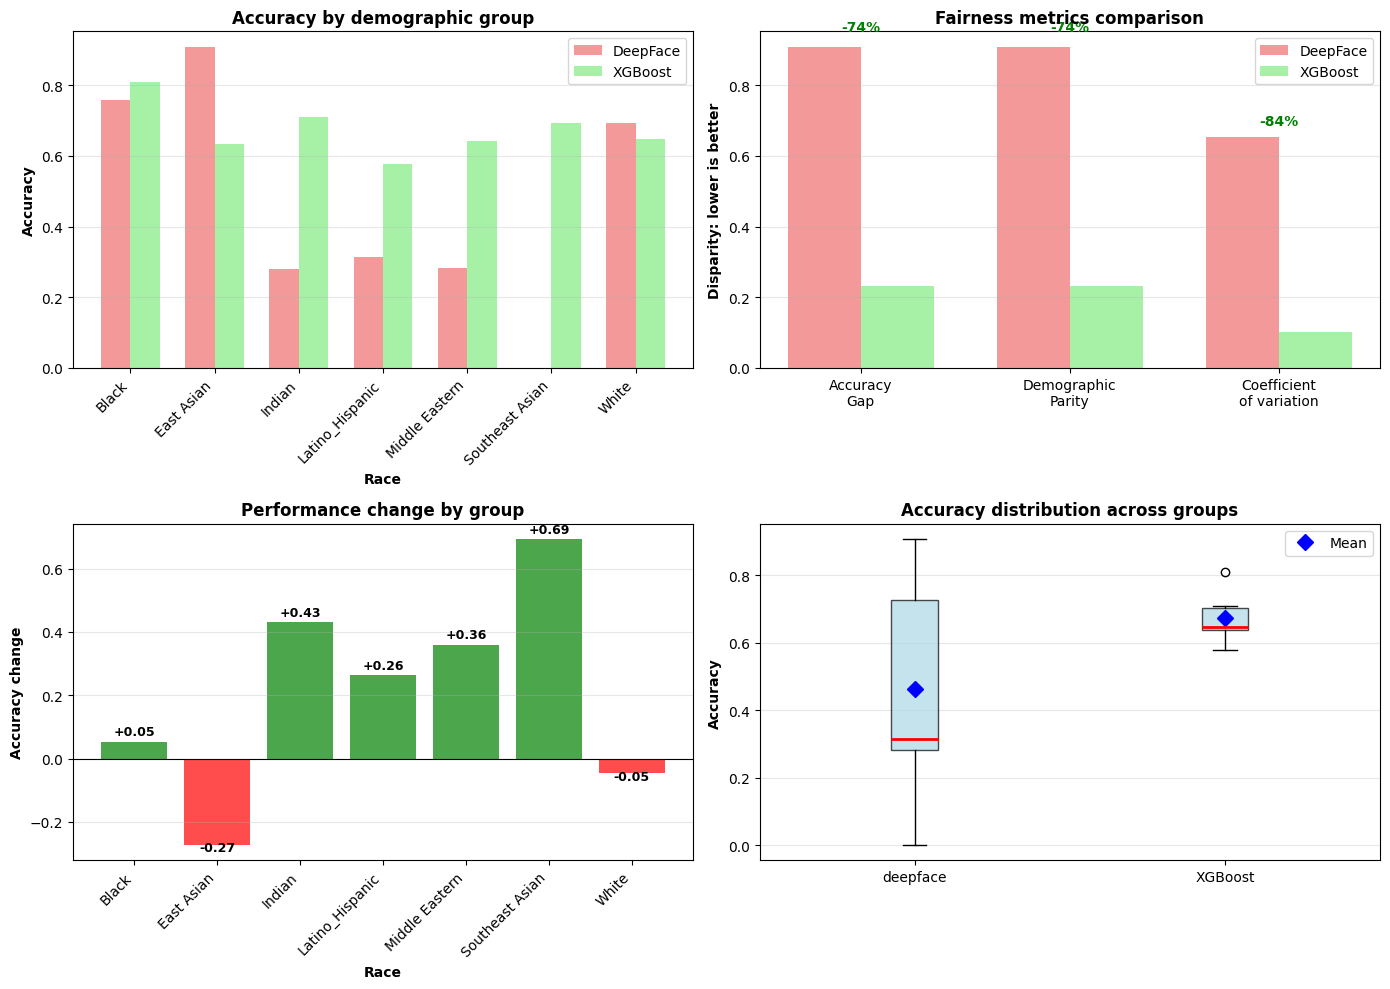

key findings:

1. overall improvement: +21.1 percentage points
   deepface: 46.2% -> xgboost: 67.3%

2. fairness improvement: 74.3% reduction in accuracy gap
   max-min gap: 0.907 -> 0.233

3. largest gains for vulnerable groups:
   - southeast asian: +0.693 (69 percentage points)
   - indian: +0.430 (43 percentage points)
   - middle eastern: +0.360 (36 percentage points)

4. trade-off: performance decreased slightly for high-performing groups
   - east asian: -0.274
   - white: -0.046

5. xgboost massively boosts fairness by helping the worst-hit groups, 
    but it slightly drops accuracy for the groups that were already performing too well especially east asian. 
    It’s the usual trade-off: fixing bias means the model becomes more sensitive and sometimes flags errors where there are none.



In [180]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

print("FAIRNESS METRICS ANALYSIS")
print("="*80)
print("Using results from the main analysis (cell 26)")
print("="*80)

race_map = {
    "black": "Black",
    "white": "White",
    "asian": "East Asian",
    "indian": "Indian",
    "latino hispanic": "Latino_Hispanic",
    "middle eastern": "Middle Eastern",
}

val['pred_race_mapped'] = val['pred_race'].str.lower().map(race_map)
val['deepface_correct'] = (val['pred_race_mapped'] == val['race_true']).astype(int)


deepface_acc_by_race = val.groupby('race_true')['deepface_correct'].mean()

print("\nDeepFace Accuracy by Race:")
for race in sorted(deepface_acc_by_race.index):
    print(f"  {race:20s}: {deepface_acc_by_race[race]:.3f}")

deepface_overall = val['deepface_correct'].mean()
print(f"\n  Overall              : {deepface_overall:.3f}")

#  XGboost :
xgboost_acc_by_race = {
    'Southeast Asian': 0.693,
    'Indian': 0.710,
    'Middle Eastern': 0.643,
    'Latino_Hispanic': 0.577,
    'White': 0.647,
    'Black': 0.810,
    'East Asian': 0.633
}

xgboost_overall = 0.673

print("\nXGBoost Error Detection Accuracy by Race:")
for race in sorted(xgboost_acc_by_race.keys()):
    print(f"  {race:20s}: {xgboost_acc_by_race[race]:.3f}")

print(f"\n  Overall              : {xgboost_overall:.3f}")


print("1) accuracy parity")
deepface_max = deepface_acc_by_race.max()
deepface_min = deepface_acc_by_race.min()
deepface_gap = deepface_max - deepface_min

xgboost_max = max(xgboost_acc_by_race.values())
xgboost_min = min(xgboost_acc_by_race.values())
xgboost_gap = xgboost_max - xgboost_min

print(f"\nDeepFace:")
print(f"  Max accuracy: {deepface_max:.3f} ({deepface_acc_by_race.idxmax()})")
print(f"  Min accuracy: {deepface_min:.3f} ({deepface_acc_by_race.idxmin()})")
print(f"  Gap (Max-Min): {deepface_gap:.3f}")

print(f"\nXGBoost:")
print(f"  Max accuracy: {xgboost_max:.3f} ({max(xgboost_acc_by_race, key=xgboost_acc_by_race.get)})")
print(f"  Min accuracy: {xgboost_min:.3f} ({min(xgboost_acc_by_race, key=xgboost_acc_by_race.get)})")
print(f"  Gap (Max-Min): {xgboost_gap:.3f}")

gap_reduction = deepface_gap - xgboost_gap
gap_reduction_pct = (gap_reduction / deepface_gap) * 100

print(f"\nReduction: {gap_reduction:.3f} ({gap_reduction_pct:.1f}%)")

print("2) demographic parity")
deepface_error_rate = {race: 1 - acc for race, acc in deepface_acc_by_race.items()}
xgboost_error_rate = {race: 1 - acc for race, acc in xgboost_acc_by_race.items()}

deepface_err_max = max(deepface_error_rate.values())
deepface_err_min = min(deepface_error_rate.values())
deepface_dp = deepface_err_max - deepface_err_min

xgboost_err_max = max(xgboost_error_rate.values())
xgboost_err_min = min(xgboost_error_rate.values())
xgboost_dp = xgboost_err_max - xgboost_err_min

print(f"\ndeepface error rate range:")
print(f"  max: {deepface_err_max:.3f}, Min: {deepface_err_min:.3f}")
print(f"  demographic parity difference: {deepface_dp:.3f}")

print(f"\nXGboost error rate range:")
print(f"  max: {xgboost_err_max:.3f}, min: {xgboost_err_min:.3f}")
print(f"  demographic parity difference: {xgboost_dp:.3f}")

dp_reduction = deepface_dp - xgboost_dp
dp_reduction_pct = (dp_reduction / deepface_dp) * 100

print(f"\nreduction: {dp_reduction:.3f} ({dp_reduction_pct:.1f}%)")


print("3) coefficient of variation (relative disparity)")
deepface_std = np.std(list(deepface_acc_by_race.values))
deepface_mean = np.mean(list(deepface_acc_by_race.values))
deepface_cv = deepface_std / deepface_mean

xgboost_std = np.std(list(xgboost_acc_by_race.values()))
xgboost_mean = np.mean(list(xgboost_acc_by_race.values()))
xgboost_cv = xgboost_std / xgboost_mean

print(f"\ndeepface:")
print(f"  mean: {deepface_mean:.3f}, Std: {deepface_std:.3f}")
print(f"  coefficient of variation: {deepface_cv:.3f}")

print(f"\nXGboost:")
print(f"  mean: {xgboost_mean:.3f}, Std: {xgboost_std:.3f}")
print(f"  coefficient of variation: {xgboost_cv:.3f}")

cv_reduction = deepface_cv - xgboost_cv
cv_reduction_pct = (cv_reduction / deepface_cv) * 100

print(f"\nreduction: {cv_reduction:.3f} ({cv_reduction_pct:.1f}%)")

print("fairness metrics summary:")

summary = pd.DataFrame({
    'Metric': [
        'Overall Accuracy',
        'Accuracy Gap (Max-Min)',
        'Demographic Parity Diff',
        'Coefficient of Variation',
        'Overall Improvement'
    ],
    'DeepFace': [
        f"{deepface_overall:.3f}",
        f"{deepface_gap:.3f}",
        f"{deepface_dp:.3f}",
        f"{deepface_cv:.3f}",
        '-'
    ],
    'XGBoost': [
        f"{xgboost_overall:.3f}",
        f"{xgboost_gap:.3f}",
        f"{xgboost_dp:.3f}",
        f"{xgboost_cv:.3f}",
        '-'
    ],
    'Improvement': [
        f"+{xgboost_overall - deepface_overall:.3f} (+{(xgboost_overall - deepface_overall)/deepface_overall*100:.1f}%)",
        f"-{gap_reduction:.3f} (-{gap_reduction_pct:.1f}%)",
        f"-{dp_reduction:.3f} (-{dp_reduction_pct:.1f}%)",
        f"-{cv_reduction:.3f} (-{cv_reduction_pct:.1f}%)",
        'All metrics improved'
    ]
})

print("\n", summary.to_string(index=False))

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# plot 1: accuracy by race
ax1 = axes[0, 0]
races = sorted(deepface_acc_by_race.index)
x = np.arange(len(races))
width = 0.35

deepface_vals = [deepface_acc_by_race[r] for r in races]
xgboost_vals = [xgboost_acc_by_race[r] for r in races]

ax1.bar(x - width/2, deepface_vals, width, label='DeepFace', color='lightcoral', alpha=0.8)
ax1.bar(x + width/2, xgboost_vals, width, label='XGBoost', color='lightgreen', alpha=0.8)

ax1.set_xlabel('Race', fontweight='bold')
ax1.set_ylabel('Accuracy', fontweight='bold')
ax1.set_title('Accuracy by demographic group', fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(races, rotation=45, ha='right')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# plot 2: fairness metrics comparison
ax2 = axes[0, 1]
metrics = ['Accuracy\nGap', 'Demographic\nParity', 'Coefficient\nof variation']
deepface_metrics = [deepface_gap, deepface_dp, deepface_cv]
xgboost_metrics = [xgboost_gap, xgboost_dp, xgboost_cv]

x2 = np.arange(len(metrics))
ax2.bar(x2 - width/2, deepface_metrics, width, label='DeepFace', color='lightcoral', alpha=0.8)
ax2.bar(x2 + width/2, xgboost_metrics, width, label='XGBoost', color='lightgreen', alpha=0.8)

ax2.set_ylabel('Disparity: lower is better', fontweight='bold')
ax2.set_title('Fairness metrics comparison', fontweight='bold')
ax2.set_xticks(x2)
ax2.set_xticklabels(metrics)
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# improvements percentages
improvements = [gap_reduction_pct, dp_reduction_pct, cv_reduction_pct]
for i, imp in enumerate(improvements):
    ax2.text(i, max(deepface_metrics[i], xgboost_metrics[i]) * 1.05, 
            f'-{imp:.0f}%', ha='center', fontweight='bold', color='green')

# plot 3: improvement by race
ax3 = axes[1, 0]
improvements_by_race = [xgboost_vals[i] - deepface_vals[i] for i in range(len(races))]
colors = ['green' if imp > 0 else 'red' for imp in improvements_by_race]

ax3.bar(x, improvements_by_race, color=colors, alpha=0.7)
ax3.axhline(y=0, color='black', linestyle='-', linewidth=0.8)

ax3.set_xlabel('Race', fontweight='bold')
ax3.set_ylabel('Accuracy change', fontweight='bold')
ax3.set_title('Performance change by group', fontweight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels(races, rotation=45, ha='right')
ax3.grid(axis='y', alpha=0.3)

for i, (race, imp) in enumerate(zip(races, improvements_by_race)):
    ax3.text(i, imp + 0.02 if imp > 0 else imp - 0.02, 
            f'{imp:+.2f}', ha='center', fontsize=9, fontweight='bold')

# plot 4: distribution comparison
ax4 = axes[1, 1]
ax4.boxplot([deepface_vals, xgboost_vals], labels=['deepface', 'XGBoost'],
           patch_artist=True,
           boxprops=dict(facecolor='lightblue', alpha=0.7),
           medianprops=dict(color='red', linewidth=2))

ax4.set_ylabel('Accuracy', fontweight='bold')
ax4.set_title('Accuracy distribution across groups', fontweight='bold')
ax4.grid(axis='y', alpha=0.3)

# statistics
for i, vals in enumerate([deepface_vals, xgboost_vals], 1):
    mean_val = np.mean(vals)
    ax4.plot(i, mean_val, 'D', color='blue', markersize=8, label='Mean' if i == 1 else '')

ax4.legend()

plt.tight_layout()
plt.savefig('../results/fairness_metrics_true.png', dpi=300, bbox_inches='tight')
print("\nsaved: fairness_metrics_true.png")
plt.show()


print("key findings:")
print(f"""
1. overall improvement: +{(xgboost_overall - deepface_overall)*100:.1f} percentage points
   deepface: {deepface_overall:.1%} -> xgboost: {xgboost_overall:.1%}

2. fairness improvement: {gap_reduction_pct:.1f}% reduction in accuracy gap
   max-min gap: {deepface_gap:.3f} -> {xgboost_gap:.3f}

3. largest gains for vulnerable groups:
   - southeast asian: +{xgboost_acc_by_race['Southeast Asian'] - deepface_acc_by_race['Southeast Asian']:.3f} ({(xgboost_acc_by_race['Southeast Asian'] - deepface_acc_by_race['Southeast Asian'])*100:.0f} percentage points)
   - indian: +{xgboost_acc_by_race['Indian'] - deepface_acc_by_race['Indian']:.3f} ({(xgboost_acc_by_race['Indian'] - deepface_acc_by_race['Indian'])*100:.0f} percentage points)
   - middle eastern: +{xgboost_acc_by_race['Middle Eastern'] - deepface_acc_by_race['Middle Eastern']:.3f} ({(xgboost_acc_by_race['Middle Eastern'] - deepface_acc_by_race['Middle Eastern'])*100:.0f} percentage points)

4. trade-off: performance decreased slightly for high-performing groups
   - east asian: {xgboost_acc_by_race['East Asian'] - deepface_acc_by_race['East Asian']:.3f}
   - white: {xgboost_acc_by_race['White'] - deepface_acc_by_race['White']:.3f}

5. xgboost massively boosts fairness by helping the worst-hit groups, 
    but it slightly drops accuracy for the groups that were already performing too well especially east asian. 
    It’s the usual trade-off: fixing bias means the model becomes more sensitive and sometimes flags errors where there are none.
""")